# Отчет по прогнозированию временных рядов с использованием ClassicalForecaster

# 1. Описание реализованного класса ClassicalForecaster

Класс `ClassicalForecaster` представляет собой программный модуль, инкапсулирующий процесс прогнозирования временных рядов с использованием классических статистических моделей. Он обеспечивает выполнение полного цикла анализа: загрузку и предобработку данных, разделение на обучающую и тестовую выборки, обучение моделей ARIMA, SARIMA и ETS, генерацию прогнозов, оценку их качества с использованием стандартных метрик и визуализацию результатов. Класс спроектирован для работы с данными на уровне отдельных товарных позиций (`item_id`) в рамках заданного магазина (`store_id`).

## Основные атрибуты класса:

*   `data`: Агрегированные данные по всему магазину.
*   `items_data`: Словарь, содержащий `pd.DataFrame` с временными рядами для каждой товарной позиции (`item_id`).
*   `items`: Список уникальных `item_id` магазина.
*   `train_data`, `test_data`: Агрегированные обучающая и тестовая выборки.
*   `models`: Словарь для хранения экземпляров обученных моделей.
*   `forecasts`: Словарь для хранения сгенерированных прогнозов.
*   `metrics`: Словарь для хранения рассчитанных метрик качества.
*   `store_id`: Идентификатор анализируемого магазина.

## Основные методы класса:

1.  **`load_and_preprocess_data`**: Выполняет загрузку, интеграцию (продажи, цены, календарь, события, кэшбэк), фильтрацию по `store_id`, агрегацию по дням для каждого `item_id`, обработку пропусков (среднее для цен, линейная интерполяция для `cnt`/`revenue`) и создание непрерывных временных рядов.
2.  **`train_test_split`**: Осуществляет разделение данных каждого `item_id` на обучающую и тестовую выборки по временному признаку.
3.  **`train_arima_model`**: Обучает модель ARIMA для заданного `item_id` и `target_col`.
4.  **`train_sarima_model`**: Обучает модель SARIMA (с учетом сезонности) для заданного `item_id` и `target_col`.
5.  **`train_ets_model`**: Обучает модель экспоненциального сглаживания (ETS) для заданного `item_id` и `target_col`.
6.  **`forecast`**: Генерирует прогноз на `steps` шагов вперед для указанной модели.
7.  **`evaluate`**: Рассчитывает метрики MAE, RMSE, MAPE, R2 путем сравнения прогноза с фактическими данными тестовой выборки на заданном горизонте (`week`, `month`, `quarter`).
8.  **`visualize_forecast`**: Создает графическое представление прогноза в сравнении с фактическими данными.
9.  **`find_best_classical_model`**: Реализует процедуру автоматического выбора модели: итеративно обучает и оценивает предопределенный набор конфигураций ARIMA, SARIMA, ETS для конкретного `item_id` и `horizon`, выбирая модель с минимальным значением MAE.
10. **`predict_with_best_model`**: Комбинирует `find_best_classical_model` и `forecast` для получения прогноза от оптимальной модели.
11. **`find_best_models_for_all_items`**: Применяет процедуру `find_best_classical_model` ко всем `item_id` магазина, агрегирует результаты и визуализирует прогнозы для лучших N товаров.

---



# 2. Ответы на ключевые вопросы

## 2.1 Какие методы предобработки данных вы использовали? Почему пробовали именно их?

Примененный комплекс методов предобработки был направлен на формирование корректных, полных и непрерывных временных рядов для каждой товарной позиции, пригодных для статистического моделирования.

**Основные методы предобработки:**

1.  **Фильтрация по `store_id`:** Изоляция данных для конкретного магазина (в данном анализе - `STORE_1`) для обеспечения специфичности анализа.
2.  **Интеграция данных:** Объединение таблиц продаж, цен и календаря, включая данные о событиях и кэшбэке, для создания многомерного представления факторов, влияющих на продажи.
3.  **Временная агрегация:** Группировка данных по дням для каждого `item_id` с вычислением суммарных (`cnt`, `revenue`) и средних (`sell_price`) показателей, а также сохранением категориальной информации (события, кэшбэк).
4.  **Обеспечение непрерывности ряда:** Использование `reindex` для создания полного временного ряда без пропусков в датах.
5.  **Обработка пропущенных значений:**
    *   *Цены:* Заполнение средним значением цены для конкретного `item_id` (простая эвристика).
    *   *Продажи/Выручка (`cnt`/`revenue`):* Замена нулевых значений на `NaN` с последующей **линейной интерполяцией**. Данный метод выбран для сохранения локальных трендов и сезонных паттернов, что является более реалистичным предположением для рядов продаж по сравнению с заполнением нулем или глобальным средним.
    *   *Граничные `NaN`:* Устранение с помощью `bfill`/`ffill`.
6.  **Обработка категориальных признаков:** Заполнение пропусков в данных о событиях маркером 'no_event' и сохранение категориальной информации при агрегации.

**Обоснование выбора:** Данные методы являются стандартными практиками при работе с временными рядами продаж. Они решают задачи консолидации данных, обеспечения их полноты и непрерывности, обработки аномалий (пропуски, нули) с минимизацией искажений структуры ряда, а также учета внешних категориальных факторов. Линейная интерполяция для рядов продаж является часто используемым компромиссом для заполнения пропусков при отсутствии более сложной модели импутации.

## 2.2 Какие модели пробовали? Почему пробовали именно их?

Были протестированы три основных семейства классических моделей временных рядов:

1.  **ARIMA (AutoRegressive Integrated Moving Average):** Моделирует зависимость текущего значения от линейной комбинации прошлых значений (AR) и прошлых ошибок (MA), после приведения ряда к стационарности (I). Конфигурации: `(2, 1, 2)`, `(3, 1, 3)`.
2.  **SARIMA (Seasonal ARIMA):** Расширение ARIMA, включающее сезонные компоненты (SAR, SI, SMA) для моделирования периодических колебаний. Конфигурации: `(1,1,1)(1,1,1,7)`, `(1,1,2)(0,1,2,7)`, `(2,1,2)(2,1,2,7)` с недельным периодом (`s=7`).
3.  **ETS (Error, Trend, Seasonality / Exponential Smoothing):** Семейство моделей, основанных на экспоненциальном сглаживании компонент ряда. Конфигурации: Аддитивная (`trend='add', seasonal='add'`) и Мультипликативная (`trend='mul', seasonal='mul'`) с недельным периодом (`periods=7`) и затухающим трендом (`damped=True`).

**Обоснование выбора:**
*   **Стандартные подходы:** ARIMA, SARIMA и ETS являются фундаментальными и широко применяемыми методами в классическом прогнозировании временных рядов.
*   **Моделирование различных аспектов:** Они представляют разные парадигмы моделирования: ARIMA/SARIMA фокусируются на автокорреляционной структуре, ETS – на декомпозиции на компоненты.
*   **Учет сезонности:** SARIMA и ETS явно предназначены для работы с сезонными данными, что критически важно для рядов продаж. Недельная сезонность (`s=7`) является наиболее ожидаемой для розничных продаж.
*   **Адаптивность:** Автоматический перебор конфигураций (`find_best_classical_model`) позволяет адаптироваться к специфике временного ряда каждого товара.

## 2.3 Как вы проверяете качество модели? На каких данных? Какие метрики используете? Чем обусловлен выбор именно этих метрик?

**Процедура валидации:**

*   **Метод:** Оценка на отложенной выборке (out-of-sample validation). Модель обучается на историческом периоде, а ее прогнозы сравниваются с фактическими данными на последующем периоде.
*   **Данные:** Тестовая выборка, составляющая последние 20% наблюдений для каждого товара (в данном анализе для `STORE_1` - период с 2015-01-23 по 2016-01-21). Оценка проводится для трех горизонтов: неделя (7 дней), месяц (30 дней), квартал (90 дней).
*   **Метрики:**
    1.  **MAE (Mean Absolute Error):** Среднее абсолютное отклонение прогноза от факта.
    2.  **RMSE (Root Mean Squared Error):** Корень из среднего квадрата отклонений.
    3.  **MAPE (Mean Absolute Percentage Error):** Среднее абсолютное отклонение в процентах от фактического значения.
    4.  **R² (Coefficient of Determination):** Доля дисперсии зависимой переменной, объясненная моделью.

**Обоснование выбора метрик:**
Данный набор метрик обеспечивает комплексную оценку точности и адекватности прогнозов:
*   **MAE:** Интуитивно понятная мера средней ошибки в единицах прогнозируемой величины; используется как основной критерий выбора модели из-за меньшей чувствительности к выбросам по сравнению с RMSE.
*   **RMSE:** Акцентирует внимание на больших ошибках; полезна для оценки риска значительных отклонений.
*   **MAPE:** Позволяет сравнивать относительную точность прогнозов для рядов с разным масштабом значений.
*   **R²:** Характеризует объяснительную способность модели относительно базового прогноза средним значением.

---


#  3. Предсказания реализованного класса ClassicalForecaster для разных горизонтов

D:\setup\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Загрузка данных для магазина: STORE_1
Данные отфильтрованы по магазину STORE_1
Найдено 15 уникальных товаров в магазине STORE_1
Обработка данных по товарам...
Агрегация данных по всему магазину...
Данные загружены и предобработаны.
Период данных: с 2011-01-29 по 2016-01-21
Данные разделены на обучающую и тестовую выборки для 15 товаров.
Период обучающих данных (агрег.): с 2011-01-29 по 2015-01-22
Период тестовых данных (агрег.): с 2015-01-23 по 2016-01-21

STORE_1_064

=== Прогнозирование по товару STORE_1_064 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_064...

Результаты тестирования моделей для товара STORE_1_064:
                      model  MAE  RMSE  MAPE  R2
ETS(t=add,s=add,p=7,d=True) 0.02  0.02  1.76 0.0
ETS(t=mul,s=mul,p=7,d=True) 0.02  0.02  1.95 0.0
SARIMA(1, 1, 2)(0, 1, 2, 7) 0.08  0.08  7.76 0.0
SARIMA(1, 1, 1)(1, 1, 1, 7) 0.08  0.08  7.85 0.0
SARIMA(2, 1, 2)(2, 1, 2, 7) 0.08  0.08  7.92 0.0
             ARIMA(2, 1, 2) 0.13  0.14 13.24 0.0
             ARIMA

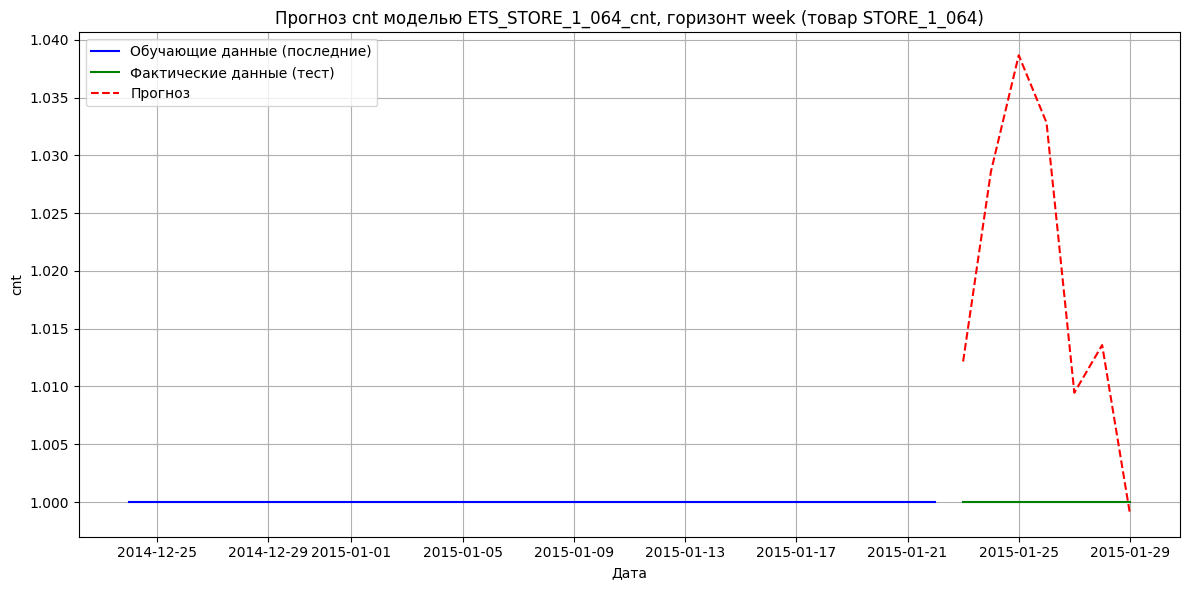

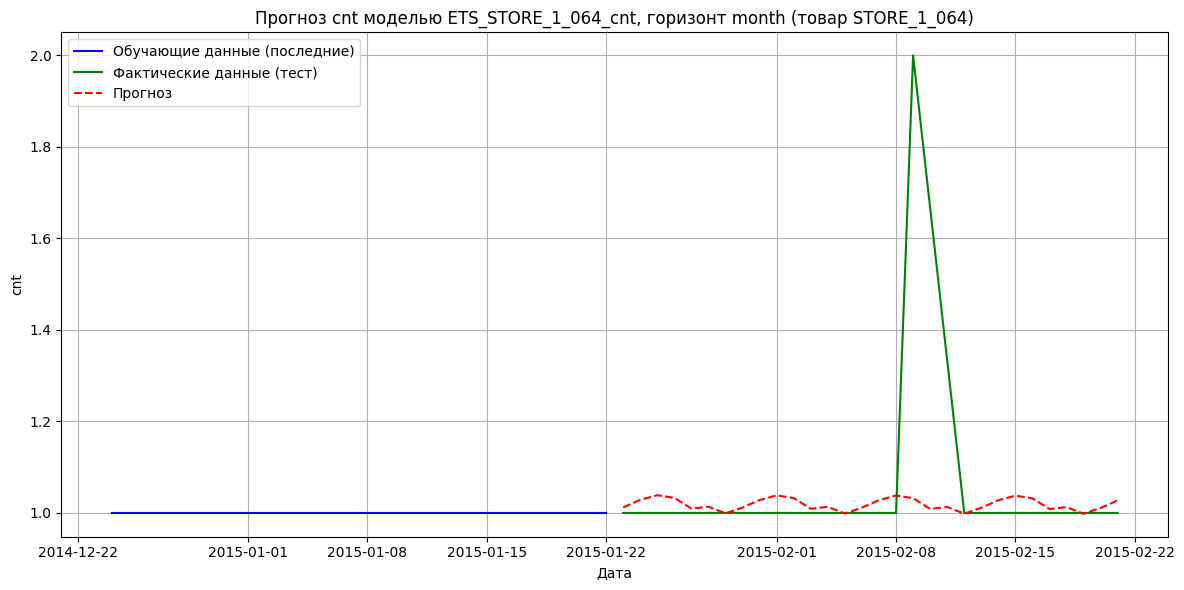

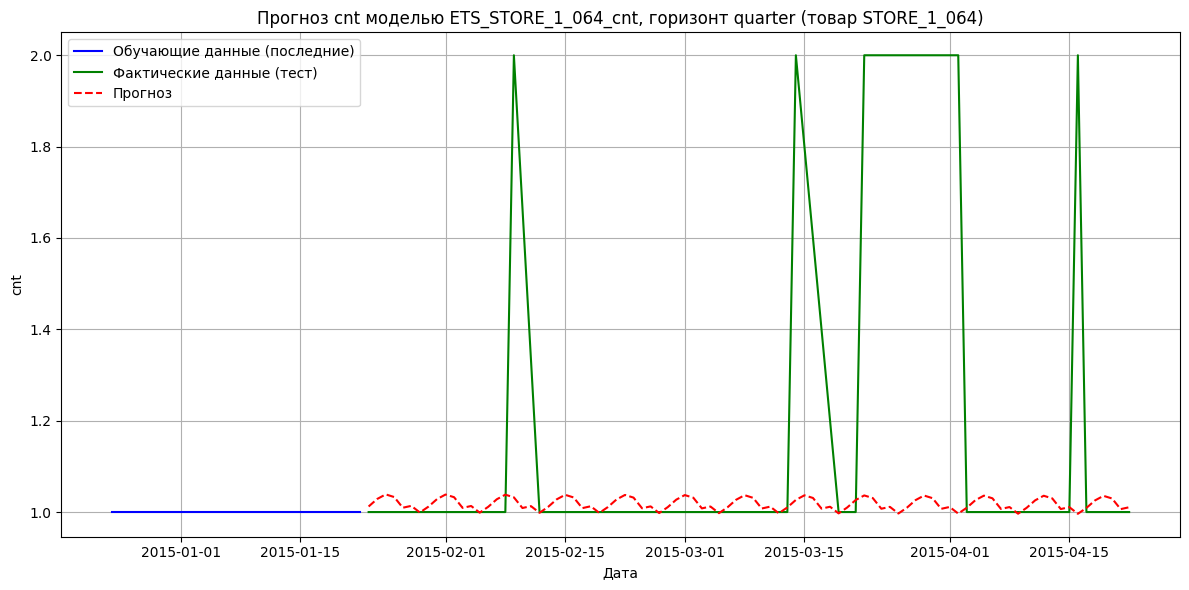


STORE_1_065

=== Прогнозирование по товару STORE_1_065 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_065...

Результаты тестирования моделей для товара STORE_1_065:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 1)(1, 1, 1, 7) 0.30  0.35 24.34  0.03
SARIMA(2, 1, 2)(2, 1, 2, 7) 0.30  0.35 24.03  0.04
             ARIMA(2, 1, 2) 0.30  0.34 23.80  0.04
SARIMA(1, 1, 2)(0, 1, 2, 7) 0.31  0.35 24.37  0.02
             ARIMA(3, 1, 3) 0.31  0.35 23.80  0.01
ETS(t=add,s=add,p=7,d=True) 0.31  0.35 24.38 -0.01
ETS(t=mul,s=mul,p=7,d=True) 0.32  0.37 24.08 -0.09

Лучшая модель для товара STORE_1_065: SARIMA(1, 1, 1)(1, 1, 1, 7)
  MAE: 0.30, RMSE: 0.35, MAPE: 24.34%, R2: 0.03

Поиск лучшей модели для cnt (month) для товара STORE_1_065...

Результаты тестирования моделей для товара STORE_1_065:
                      model  MAE  RMSE  MAPE    R2
ETS(t=mul,s=mul,p=7,d=True) 0.27  0.30 25.38 -0.69
ETS(t=add,s=add,p=7,d=True) 0.30  0.32 27.71 -0.81
             ARIMA(3, 1, 

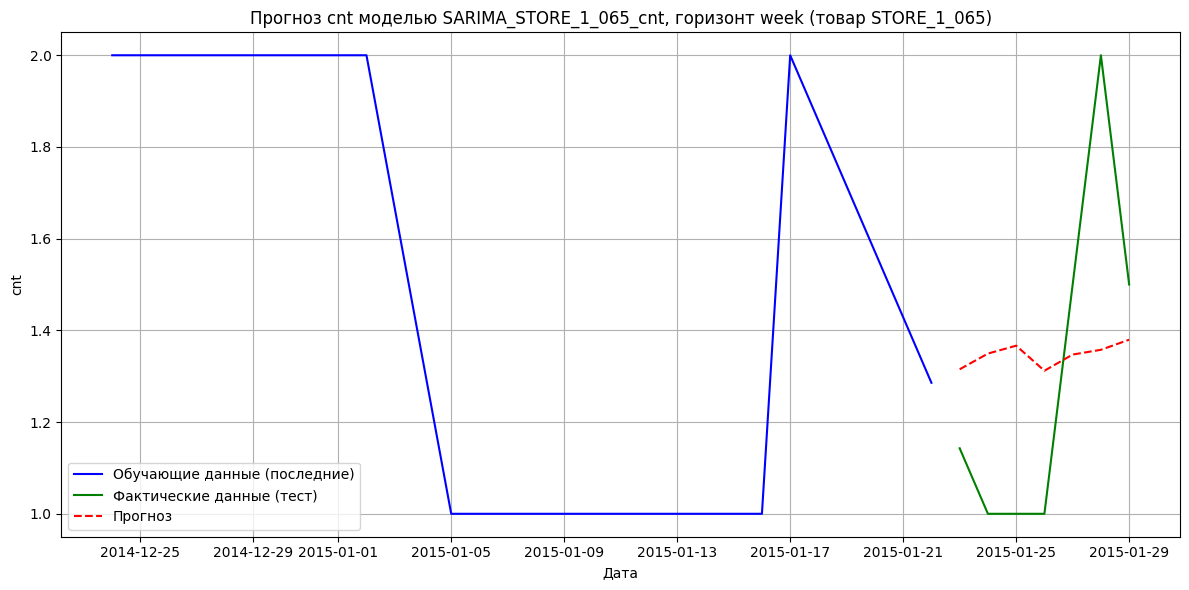

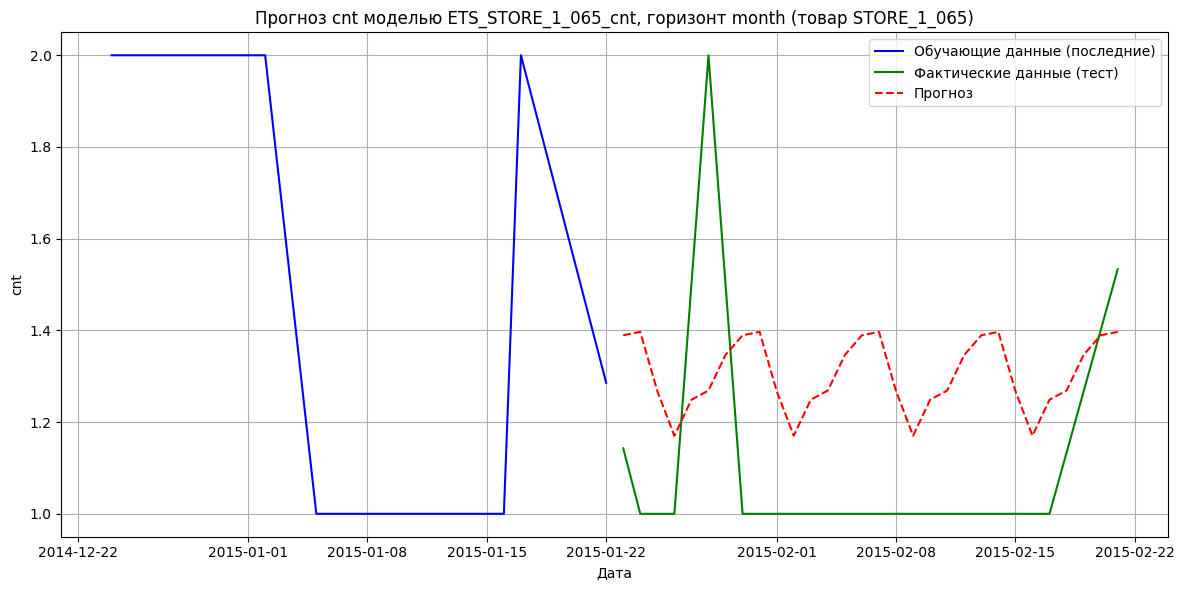

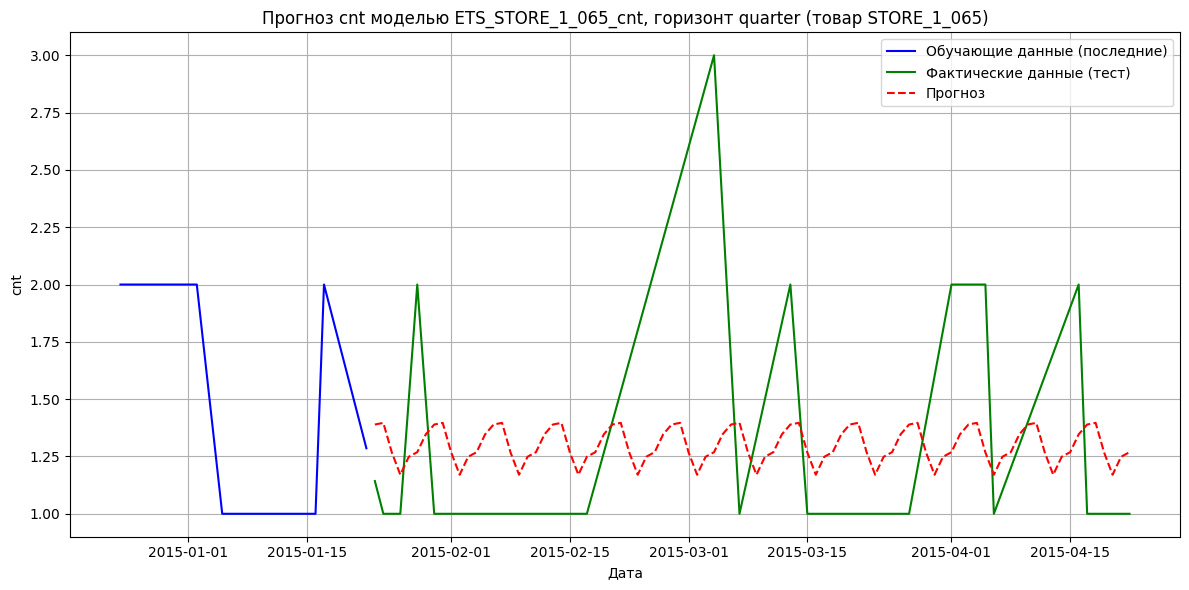


STORE_1_325

=== Прогнозирование по товару STORE_1_325 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_325...

Результаты тестирования моделей для товара STORE_1_325:
                      model  MAE  RMSE   MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.93  2.35 127.51  0.17
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.93  2.40 133.01  0.13
SARIMA(2, 1, 2)(2, 1, 2, 7) 1.95  2.36 126.71  0.16
ETS(t=add,s=add,p=7,d=True) 1.99  2.55 141.91  0.02
ETS(t=mul,s=mul,p=7,d=True) 2.17  2.62 145.80 -0.04
             ARIMA(2, 1, 2) 2.33  2.75 144.40 -0.14
             ARIMA(3, 1, 3) 2.38  2.68 134.40 -0.08

Лучшая модель для товара STORE_1_325: SARIMA(1, 1, 2)(0, 1, 2, 7)
  MAE: 1.93, RMSE: 2.35, MAPE: 127.51%, R2: 0.17

Поиск лучшей модели для cnt (month) для товара STORE_1_325...

Результаты тестирования моделей для товара STORE_1_325:
                      model  MAE  RMSE  MAPE    R2
ETS(t=add,s=add,p=7,d=True) 2.79  4.03 99.95  0.00
SARIMA(1, 1, 1)(1, 1, 1, 7) 2.79  4.04 96.22 -0.00
ETS(t=mul,s=mul,

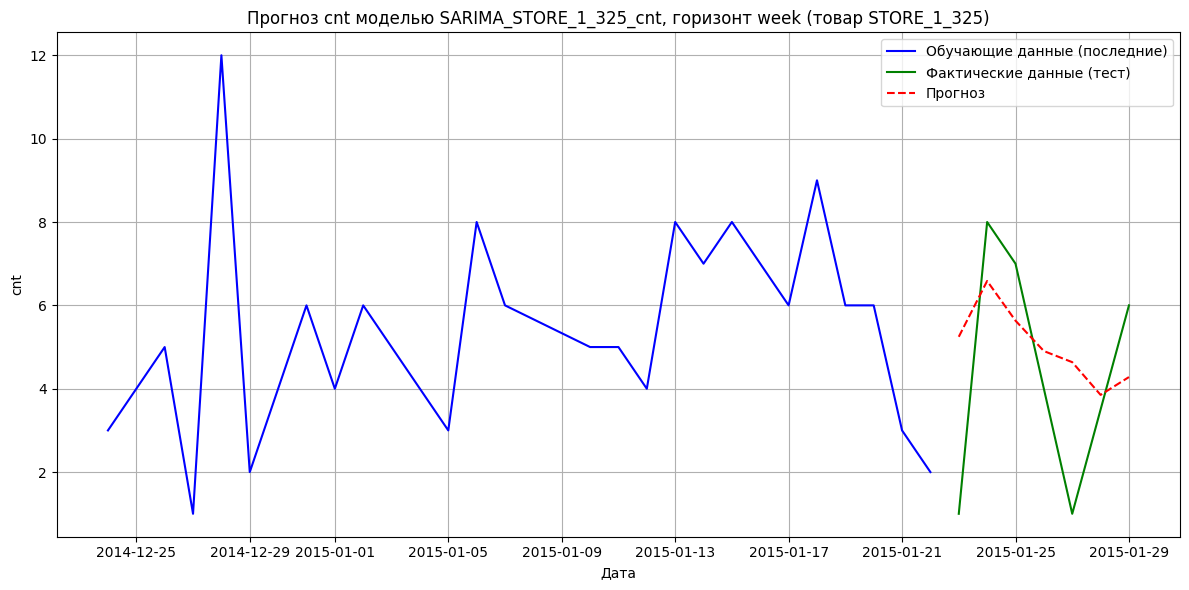

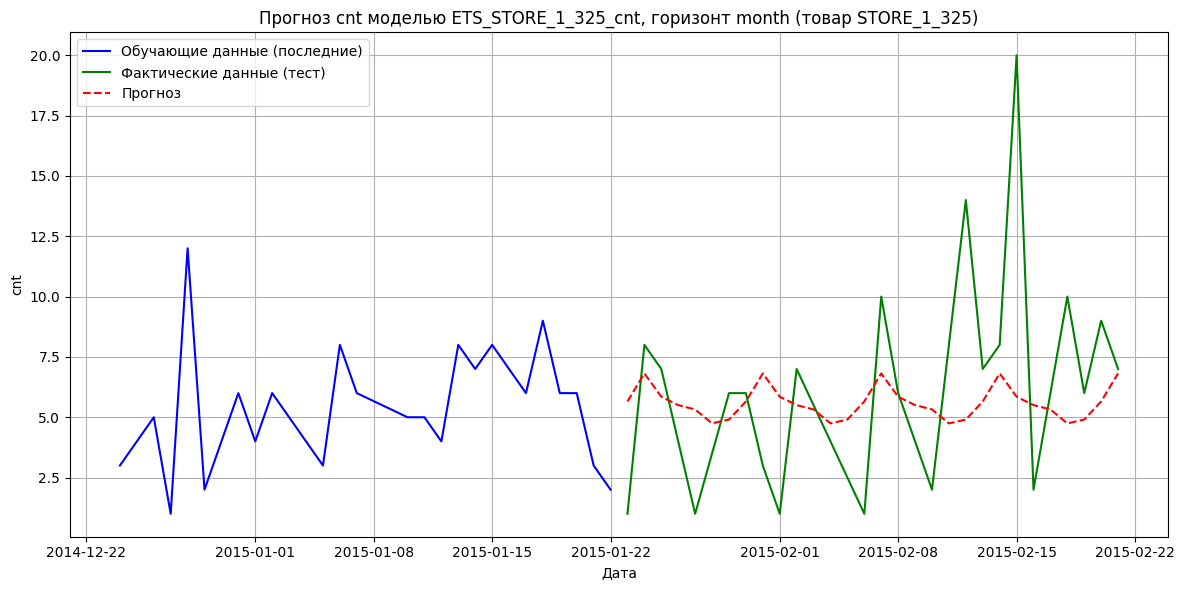

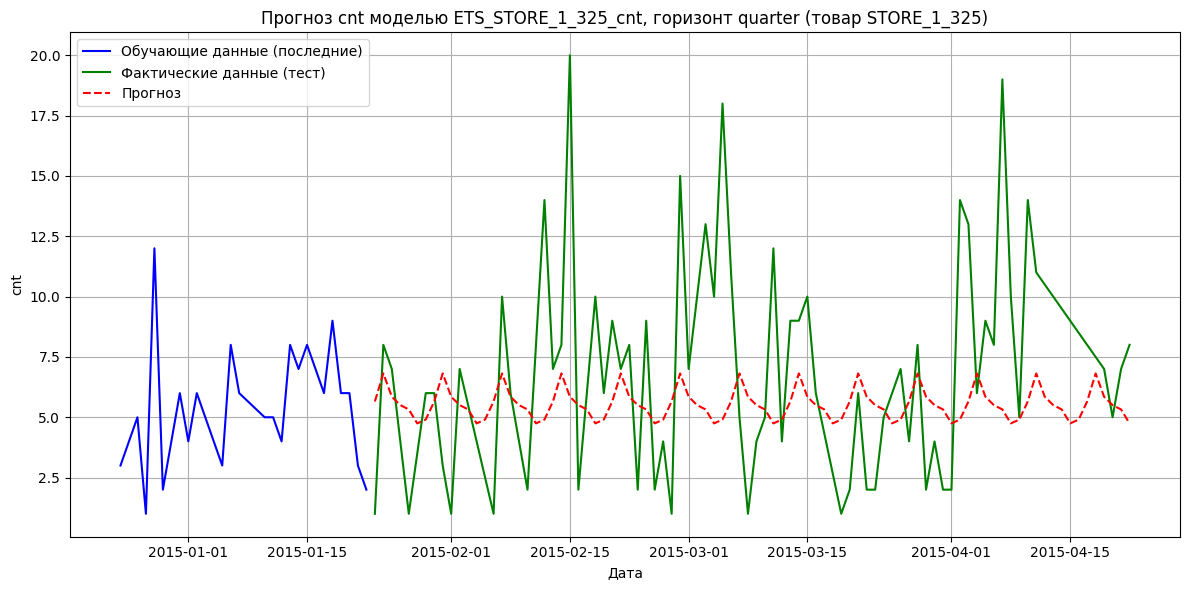


STORE_1_376

=== Прогнозирование по товару STORE_1_376 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_376...

Результаты тестирования моделей для товара STORE_1_376:
                      model  MAE  RMSE   MAPE     R2
             ARIMA(3, 1, 3) 0.91  0.99  72.39  -3.56
             ARIMA(2, 1, 2) 0.91  0.99  72.64  -3.59
SARIMA(1, 1, 1)(1, 1, 1, 7) 0.95  1.02  74.88  -3.82
SARIMA(2, 1, 2)(2, 1, 2, 7) 0.95  1.02  75.27  -3.88
SARIMA(1, 1, 2)(0, 1, 2, 7) 0.98  1.05  76.85  -4.10
ETS(t=add,s=add,p=7,d=True) 1.71  1.78 137.09 -13.77
ETS(t=mul,s=mul,p=7,d=True) 1.97  2.04 156.94 -18.46

Лучшая модель для товара STORE_1_376: ARIMA(3, 1, 3)
  MAE: 0.91, RMSE: 0.99, MAPE: 72.39%, R2: -3.56

Поиск лучшей модели для cnt (month) для товара STORE_1_376...

Результаты тестирования моделей для товара STORE_1_376:
                      model  MAE  RMSE   MAPE    R2
             ARIMA(2, 1, 2) 0.91  1.17  62.74 -0.16
             ARIMA(3, 1, 3) 0.92  1.17  63.10 -0.16
SARIMA(2, 1, 2)(2,

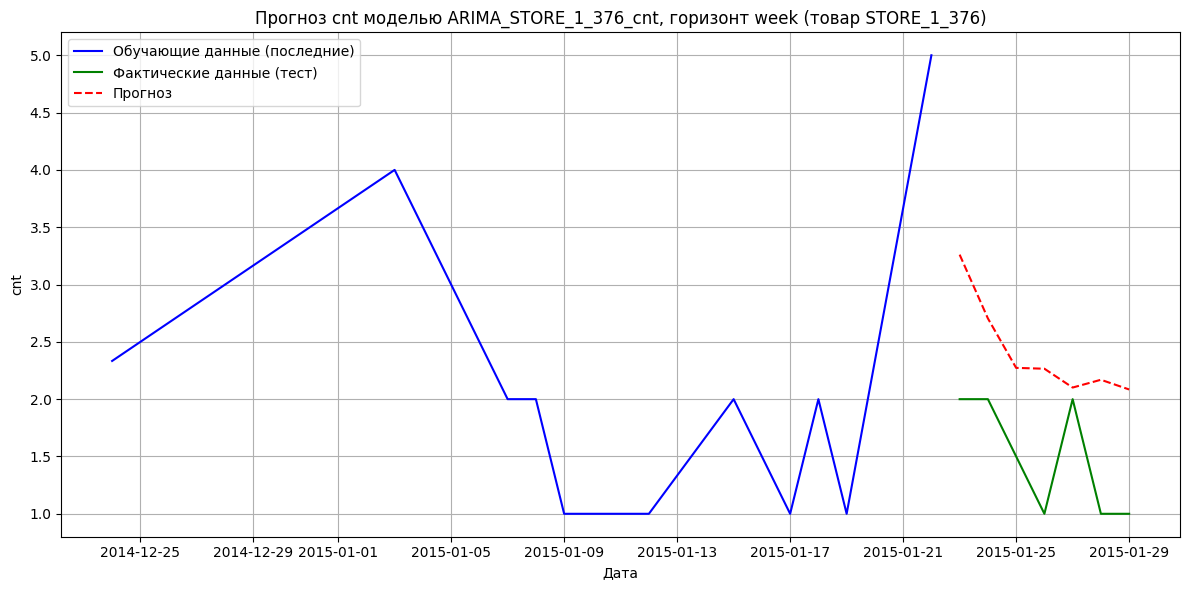

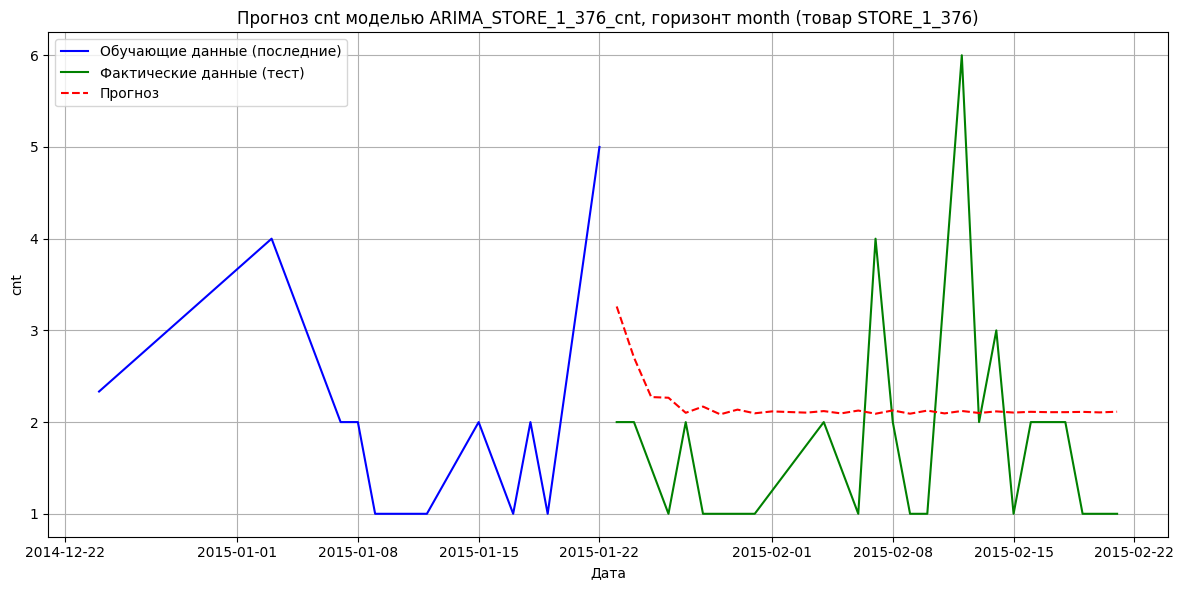

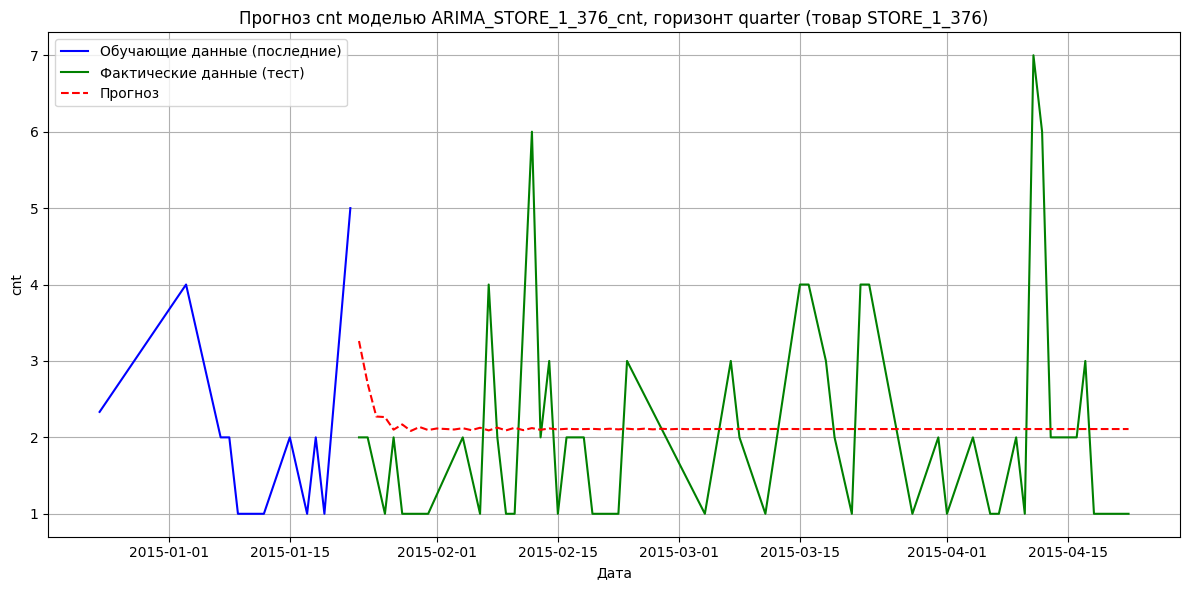


STORE_1_090

=== Прогнозирование по товару STORE_1_090 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_090...

Результаты тестирования моделей для товара STORE_1_090:
                      model   MAE  RMSE  MAPE   R2
SARIMA(1, 1, 1)(1, 1, 1, 7) 11.78 13.45 18.36 0.74
SARIMA(2, 1, 2)(2, 1, 2, 7) 12.00 13.63 18.92 0.73
SARIMA(1, 1, 2)(0, 1, 2, 7) 12.40 15.80 15.71 0.64
ETS(t=mul,s=mul,p=7,d=True) 15.29 19.52 18.98 0.45
ETS(t=add,s=add,p=7,d=True) 15.64 19.51 20.02 0.45
             ARIMA(2, 1, 2) 16.14 19.18 23.10 0.47
             ARIMA(3, 1, 3) 17.47 19.86 26.54 0.43

Лучшая модель для товара STORE_1_090: SARIMA(1, 1, 1)(1, 1, 1, 7)
  MAE: 11.78, RMSE: 13.45, MAPE: 18.36%, R2: 0.74

Поиск лучшей модели для cnt (month) для товара STORE_1_090...

Результаты тестирования моделей для товара STORE_1_090:
                      model   MAE  RMSE  MAPE   R2
SARIMA(1, 1, 1)(1, 1, 1, 7) 15.73 20.94 27.72 0.30
SARIMA(2, 1, 2)(2, 1, 2, 7) 15.77 20.85 27.68 0.30
SARIMA(1, 1, 2)(0, 1, 2

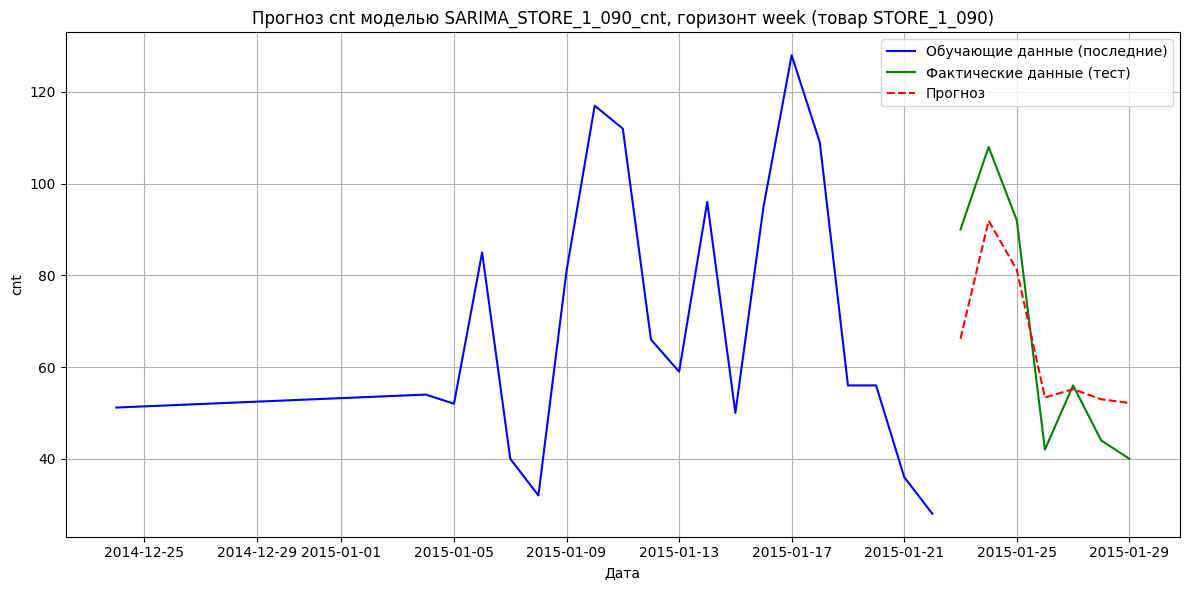

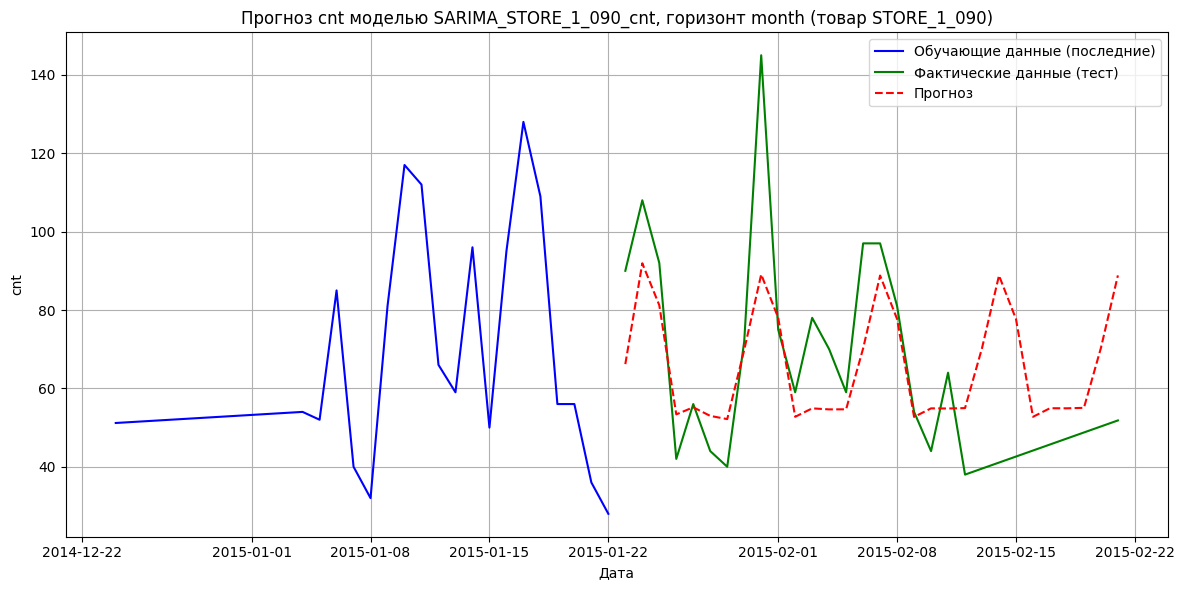

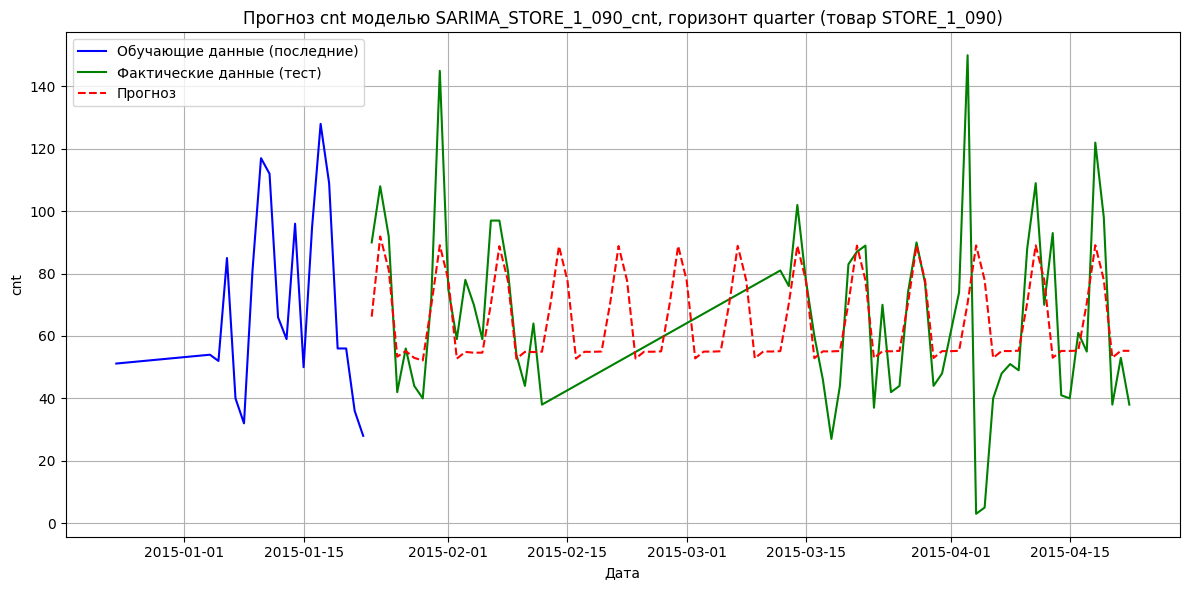


STORE_1_252

=== Прогнозирование по товару STORE_1_252 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_252...

Результаты тестирования моделей для товара STORE_1_252:
                      model  MAE  RMSE  MAPE    R2
ETS(t=mul,s=mul,p=7,d=True) 2.05  2.53 41.35  0.11
             ARIMA(3, 1, 3) 2.18  2.90 46.59 -0.17
SARIMA(2, 1, 2)(2, 1, 2, 7) 2.36  2.66 41.70  0.01
SARIMA(1, 1, 1)(1, 1, 1, 7) 2.47  2.80 43.80 -0.10
SARIMA(1, 1, 2)(0, 1, 2, 7) 2.48  2.76 43.49 -0.07
ETS(t=add,s=add,p=7,d=True) 2.59  2.83 43.97 -0.12
             ARIMA(2, 1, 2) 2.76  3.36 55.99 -0.58

Лучшая модель для товара STORE_1_252: ETS(t=mul,s=mul,p=7,d=True)
  MAE: 2.05, RMSE: 2.53, MAPE: 41.35%, R2: 0.11

Поиск лучшей модели для cnt (month) для товара STORE_1_252...

Результаты тестирования моделей для товара STORE_1_252:
                      model  MAE  RMSE  MAPE    R2
             ARIMA(3, 1, 3) 5.23  6.41 52.53 -0.28
SARIMA(2, 1, 2)(2, 1, 2, 7) 5.38  6.50 53.07 -0.32
SARIMA(1, 1, 2)(0, 1, 2, 

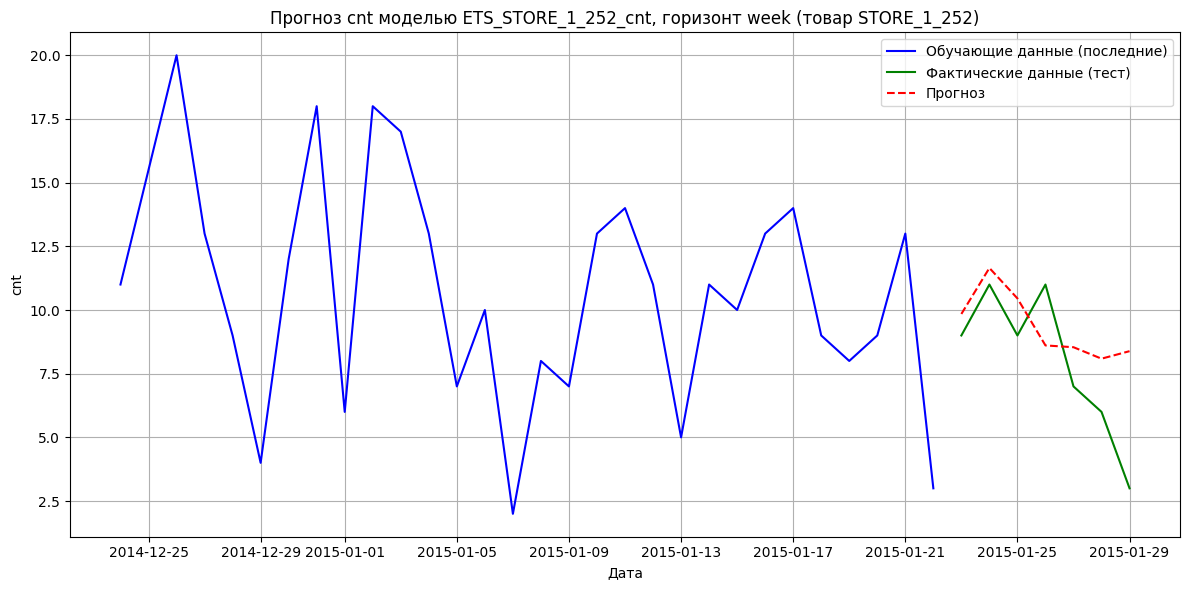

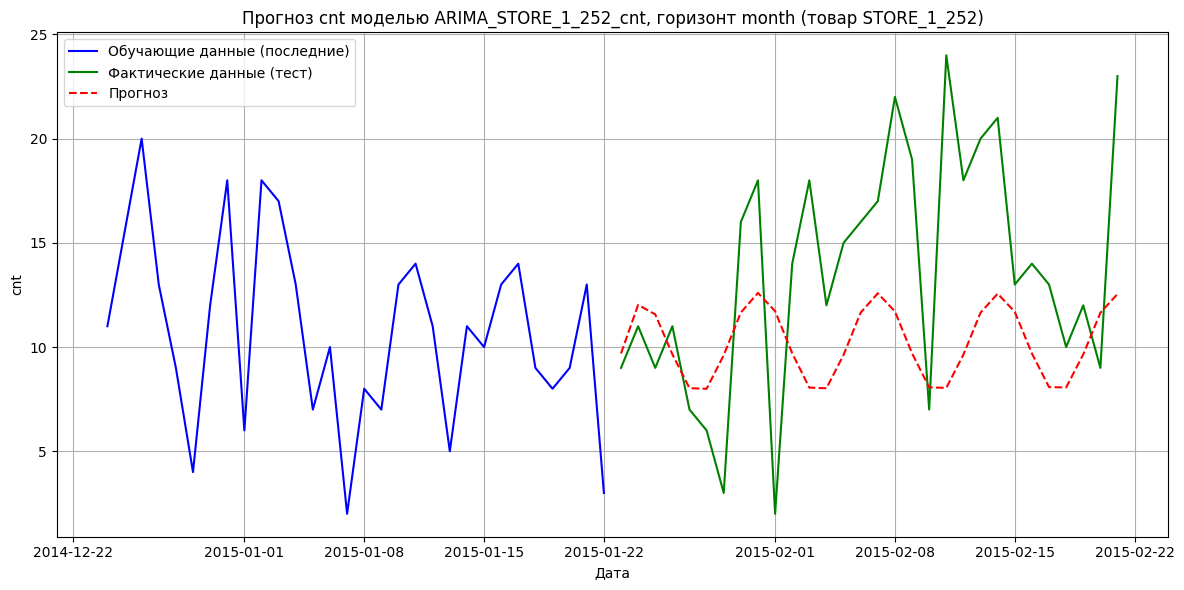

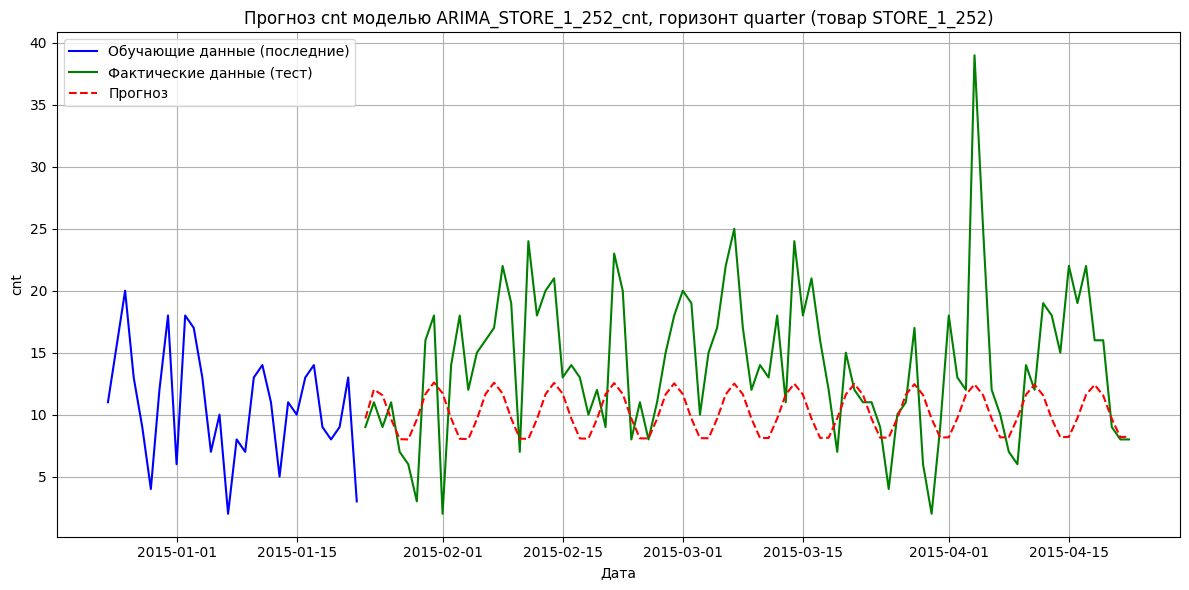


STORE_1_339

=== Прогнозирование по товару STORE_1_339 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_339...

Результаты тестирования моделей для товара STORE_1_339:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.74  2.07 85.46  0.32
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.75  2.08 85.78  0.31
SARIMA(2, 1, 2)(2, 1, 2, 7) 1.78  2.12 85.65  0.29
ETS(t=add,s=add,p=7,d=True) 1.81  2.19 86.35  0.24
ETS(t=mul,s=mul,p=7,d=True) 1.89  2.28 87.58  0.18
             ARIMA(2, 1, 2) 2.04  2.53 97.71 -0.02
             ARIMA(3, 1, 3) 2.06  2.55 96.46 -0.03

Лучшая модель для товара STORE_1_339: SARIMA(1, 1, 2)(0, 1, 2, 7)
  MAE: 1.74, RMSE: 2.07, MAPE: 85.46%, R2: 0.32

Поиск лучшей модели для cnt (month) для товара STORE_1_339...

Результаты тестирования моделей для товара STORE_1_339:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.94  2.43 57.92  0.05
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.94  2.43 58.00  0.05
SARIMA(2, 1, 2)(2, 1, 2, 

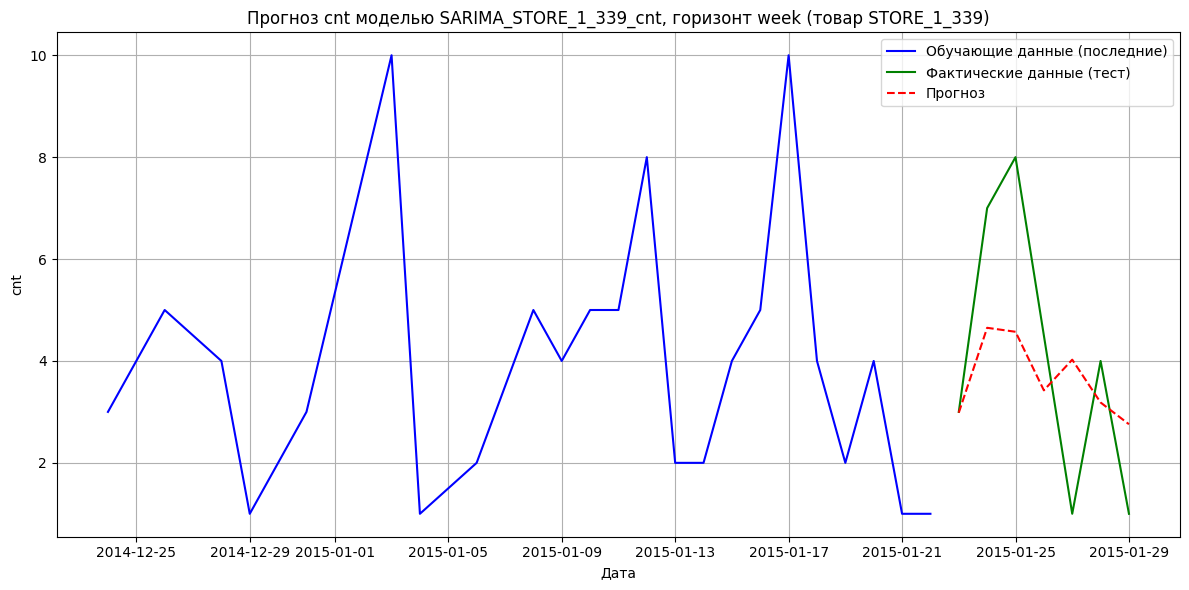

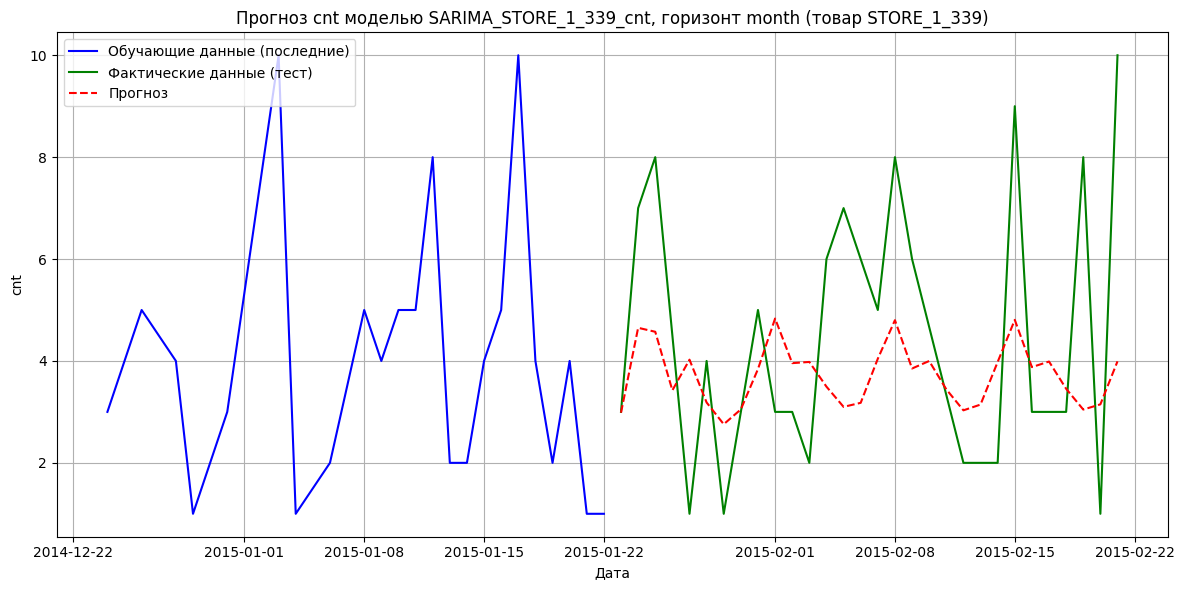

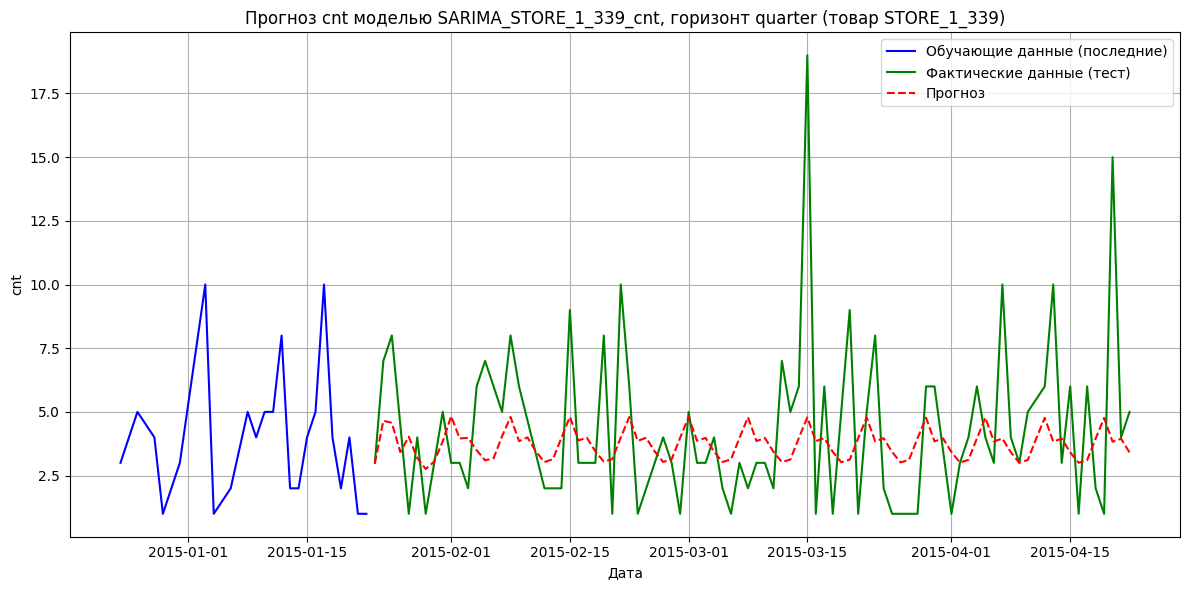


STORE_1_546

=== Прогнозирование по товару STORE_1_546 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_546...

Результаты тестирования моделей для товара STORE_1_546:
                      model  MAE  RMSE  MAPE      R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.08  1.22 74.61  -72.30
             ARIMA(2, 1, 2) 1.10  1.12 79.32  -60.53
SARIMA(2, 1, 2)(2, 1, 2, 7) 1.19  1.35 81.83  -88.26
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.29  1.42 90.28  -98.12
             ARIMA(3, 1, 3) 1.31  1.33 92.08  -85.33
ETS(t=mul,s=mul,p=7,d=True) 1.34  1.45 94.03 -101.97
ETS(t=add,s=add,p=7,d=True) 1.36  1.53 94.62 -114.34

Лучшая модель для товара STORE_1_546: SARIMA(1, 1, 2)(0, 1, 2, 7)
  MAE: 1.08, RMSE: 1.22, MAPE: 74.61%, R2: -72.30

Поиск лучшей модели для cnt (month) для товара STORE_1_546...

Результаты тестирования моделей для товара STORE_1_546:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.27  1.70 61.37 -0.19
             ARIMA(2, 1, 2) 1.28  1.56 62.52  0.00
       

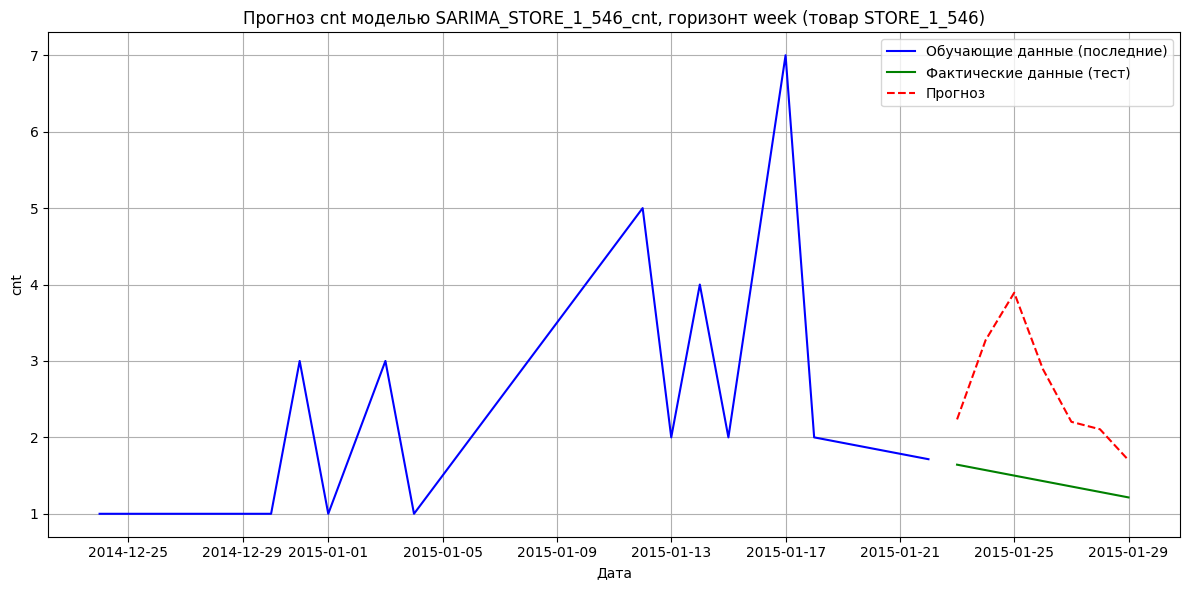

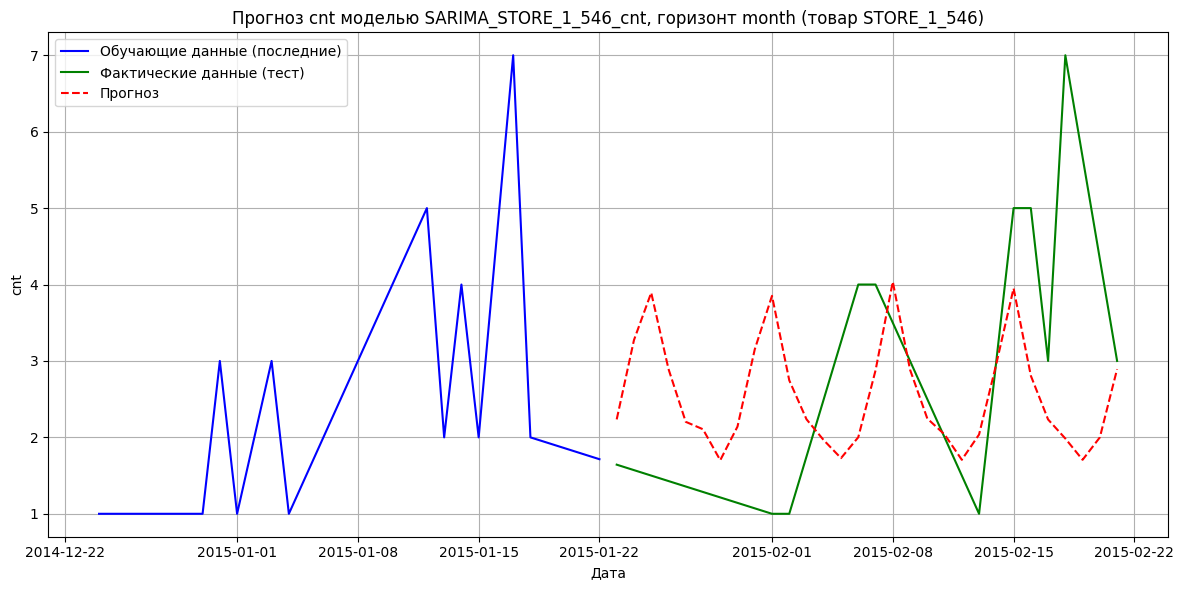

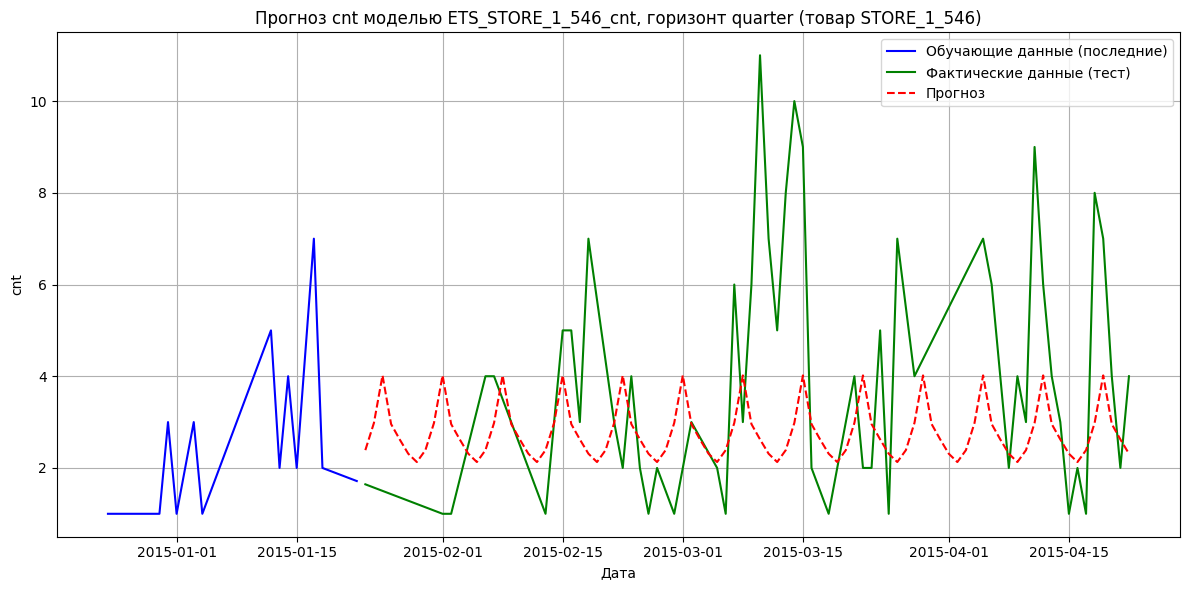


STORE_1_547

=== Прогнозирование по товару STORE_1_547 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_547...

Результаты тестирования моделей для товара STORE_1_547:
                      model  MAE  RMSE  MAPE    R2
             ARIMA(3, 1, 3) 0.78  0.80 14.36  0.13
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.13  1.54 18.96 -2.24
SARIMA(2, 1, 2)(2, 1, 2, 7) 1.14  1.59 18.15 -2.46
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.46  1.94 23.31 -4.10
ETS(t=add,s=add,p=7,d=True) 2.07  2.36 35.19 -6.57
             ARIMA(2, 1, 2) 2.11  2.28 35.53 -6.08
ETS(t=mul,s=mul,p=7,d=True) 2.13  2.30 35.84 -6.22

Лучшая модель для товара STORE_1_547: ARIMA(3, 1, 3)
  MAE: 0.78, RMSE: 0.80, MAPE: 14.36%, R2: 0.13

Поиск лучшей модели для cnt (month) для товара STORE_1_547...

Результаты тестирования моделей для товара STORE_1_547:
                      model  MAE  RMSE  MAPE    R2
             ARIMA(3, 1, 3) 5.93  8.59 33.71 -0.49
SARIMA(1, 1, 1)(1, 1, 1, 7) 8.59 11.11 53.23 -1.49
SARIMA(2, 1, 2)(2, 1, 2, 7) 9.34 11.87

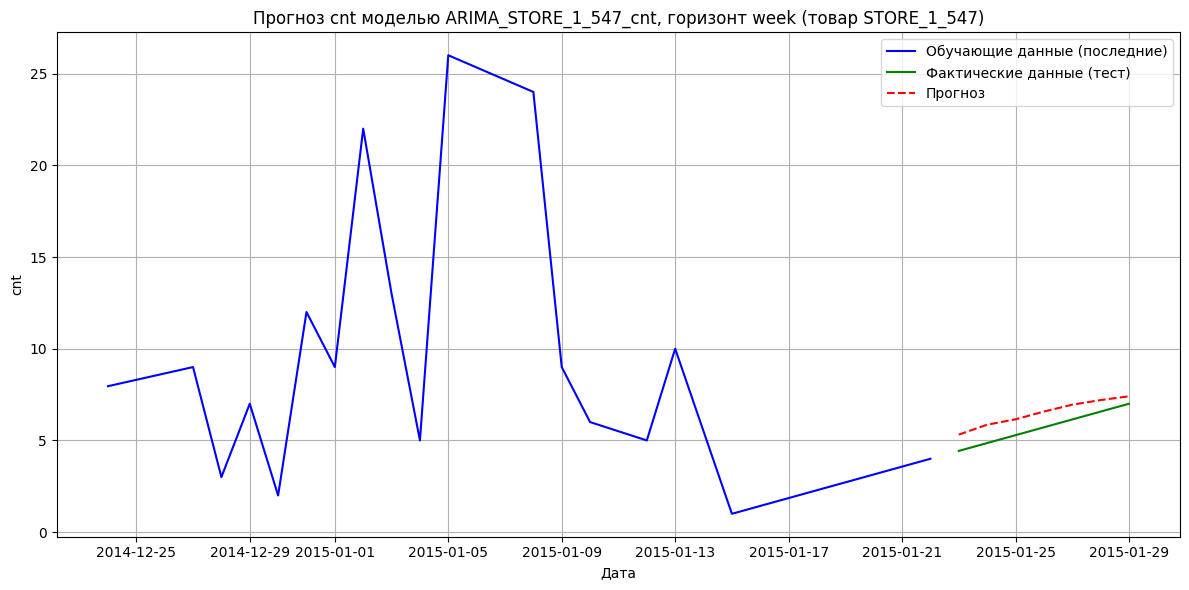

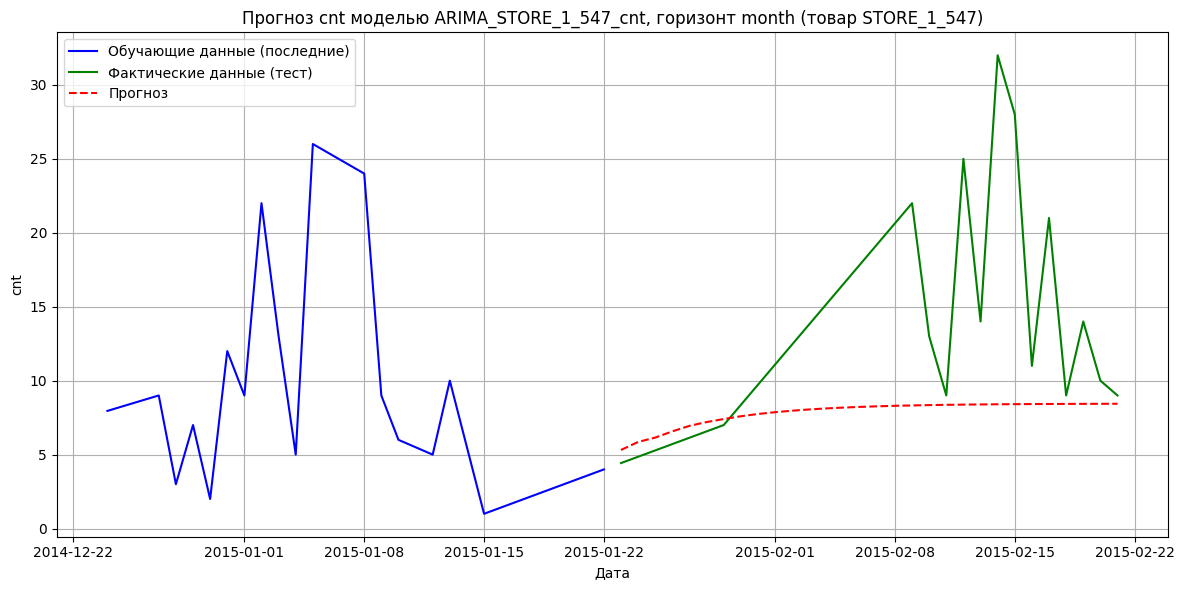

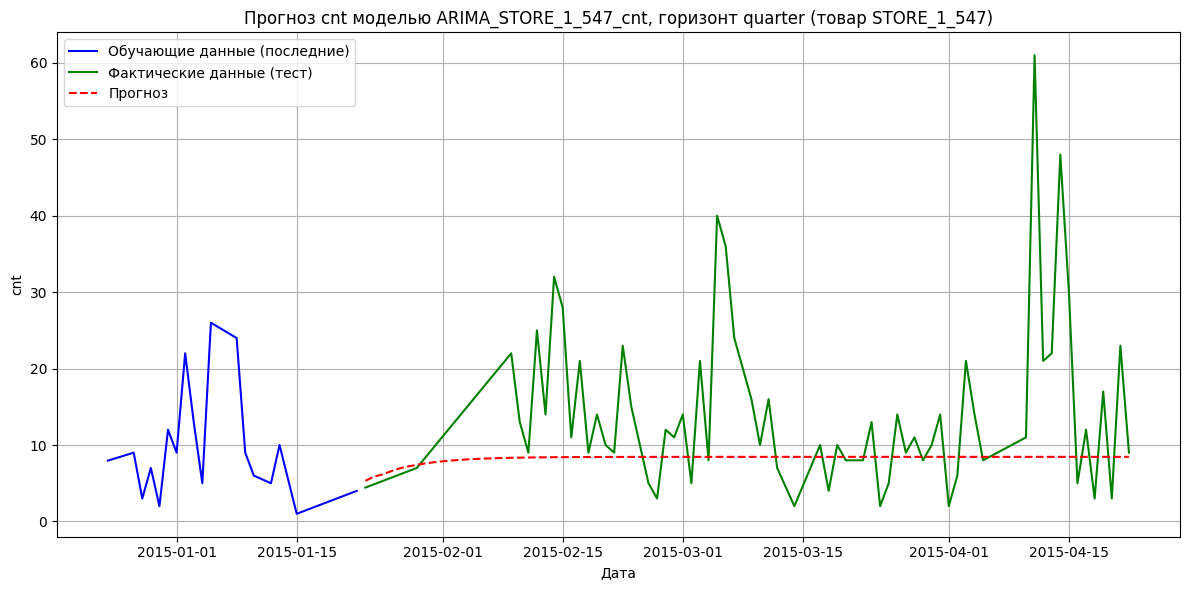


STORE_1_555

=== Прогнозирование по товару STORE_1_555 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_555...

Результаты тестирования моделей для товара STORE_1_555:
                      model  MAE  RMSE  MAPE    R2
ETS(t=mul,s=mul,p=7,d=True) 2.11  2.41 14.76 -0.32
             ARIMA(3, 1, 3) 2.40  2.82 17.16 -0.80
             ARIMA(2, 1, 2) 2.54  2.93 18.04 -0.95
ETS(t=add,s=add,p=7,d=True) 2.60  3.15 17.71 -1.25
SARIMA(1, 1, 2)(0, 1, 2, 7) 2.71  3.33 18.52 -1.51
SARIMA(2, 1, 2)(2, 1, 2, 7) 2.77  3.16 18.85 -1.26
SARIMA(1, 1, 1)(1, 1, 1, 7) 2.81  3.23 19.27 -1.37

Лучшая модель для товара STORE_1_555: ETS(t=mul,s=mul,p=7,d=True)
  MAE: 2.11, RMSE: 2.41, MAPE: 14.76%, R2: -0.32

Поиск лучшей модели для cnt (month) для товара STORE_1_555...

Результаты тестирования моделей для товара STORE_1_555:
                      model  MAE  RMSE  MAPE    R2
             ARIMA(3, 1, 3) 6.05  8.13 26.95 -0.13
SARIMA(2, 1, 2)(2, 1, 2, 7) 6.17  8.33 27.07 -0.18
SARIMA(1, 1, 1)(1, 1, 1,

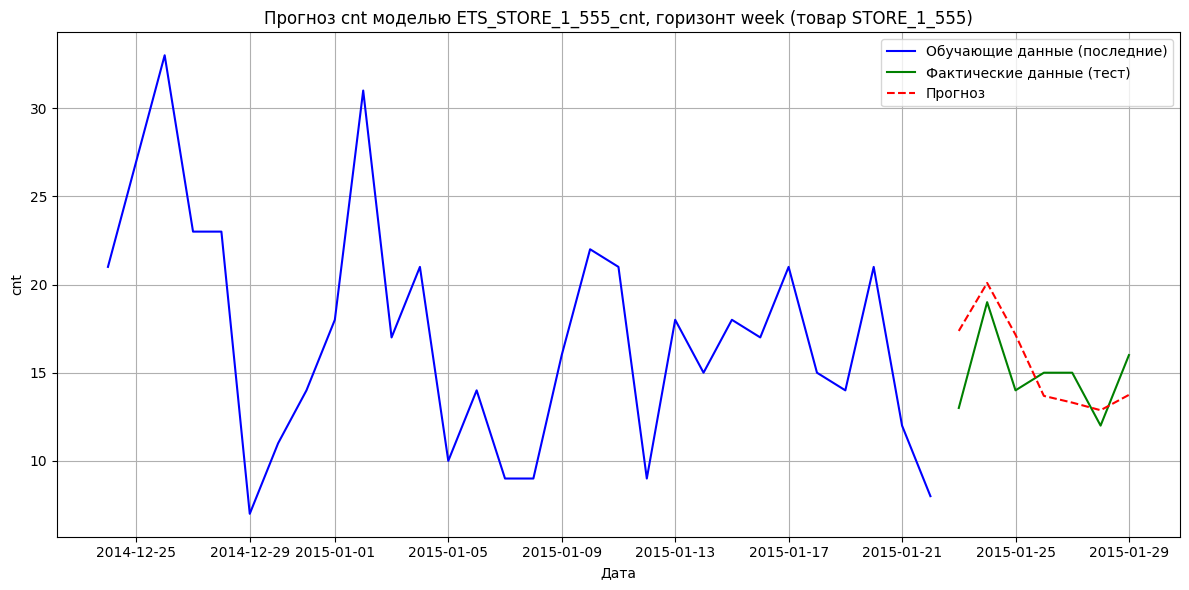

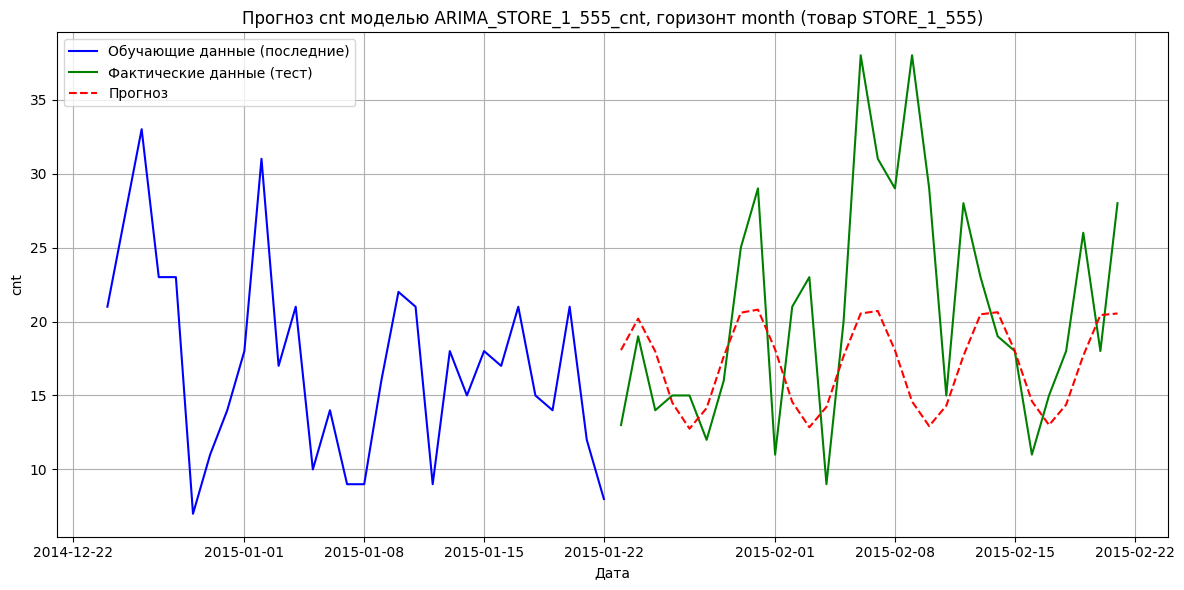

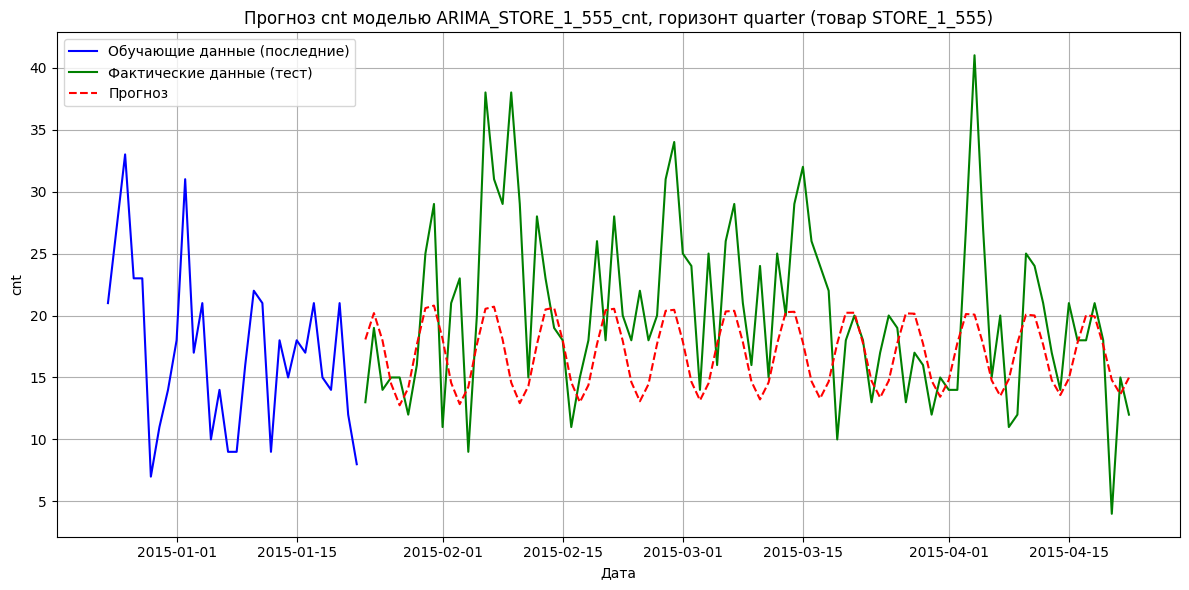


STORE_1_584

=== Прогнозирование по товару STORE_1_584 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_584...

Результаты тестирования моделей для товара STORE_1_584:
                      model  MAE  RMSE  MAPE    R2
ETS(t=mul,s=mul,p=7,d=True) 0.69  0.87 43.08 -0.67
ETS(t=add,s=add,p=7,d=True) 0.80  1.05 51.50 -1.39
SARIMA(1, 1, 2)(0, 1, 2, 7) 0.84  1.08 54.32 -1.54
SARIMA(2, 1, 2)(2, 1, 2, 7) 0.91  1.12 57.92 -1.75
             ARIMA(2, 1, 2) 0.96  1.03 59.08 -1.29
             ARIMA(3, 1, 3) 0.99  1.04 59.80 -1.36
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.01  1.23 65.60 -2.28

Лучшая модель для товара STORE_1_584: ETS(t=mul,s=mul,p=7,d=True)
  MAE: 0.69, RMSE: 0.87, MAPE: 43.08%, R2: -0.67

Поиск лучшей модели для cnt (month) для товара STORE_1_584...

Результаты тестирования моделей для товара STORE_1_584:
                      model  MAE  RMSE  MAPE    R2
ETS(t=add,s=add,p=7,d=True) 1.55  2.39 59.63 -0.04
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.56  2.36 61.50 -0.02
SARIMA(2, 1, 2)(2, 1, 2,

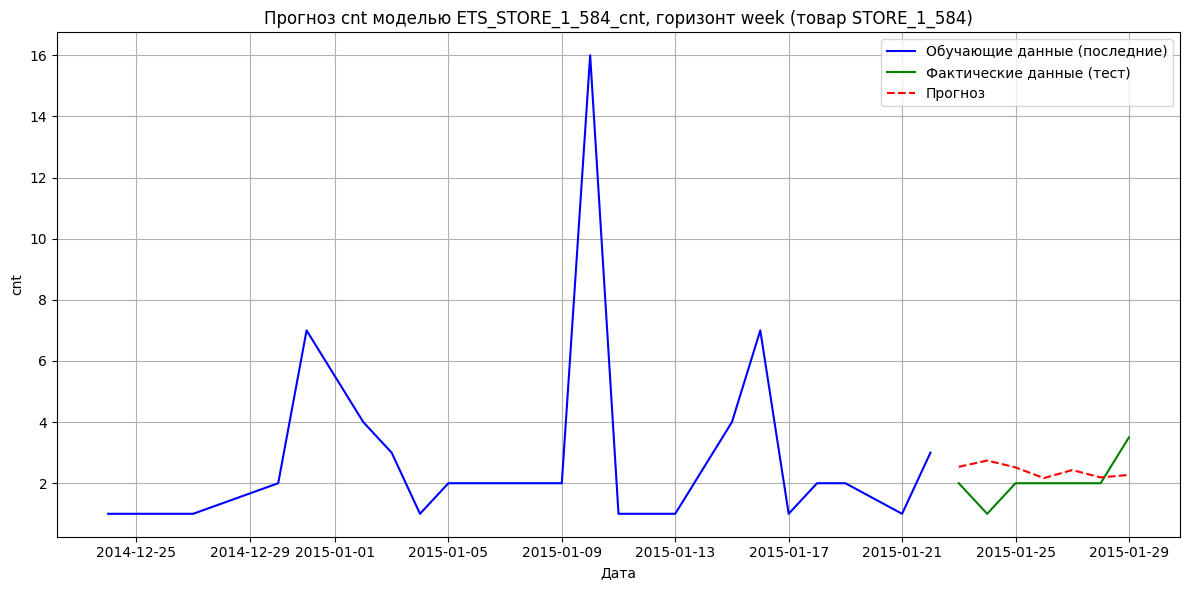

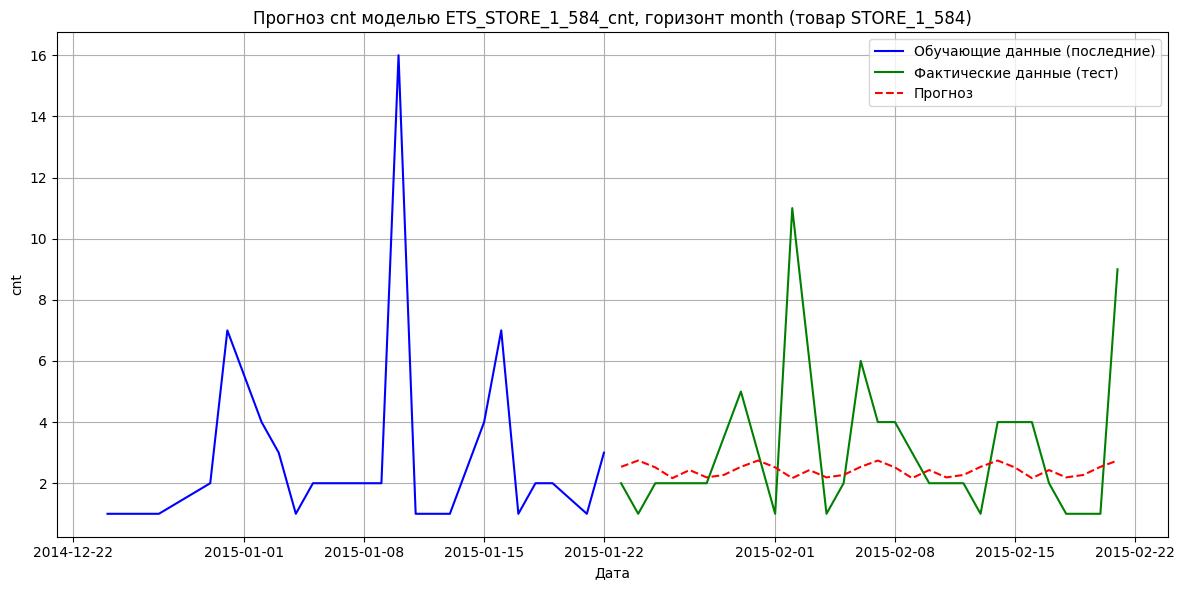

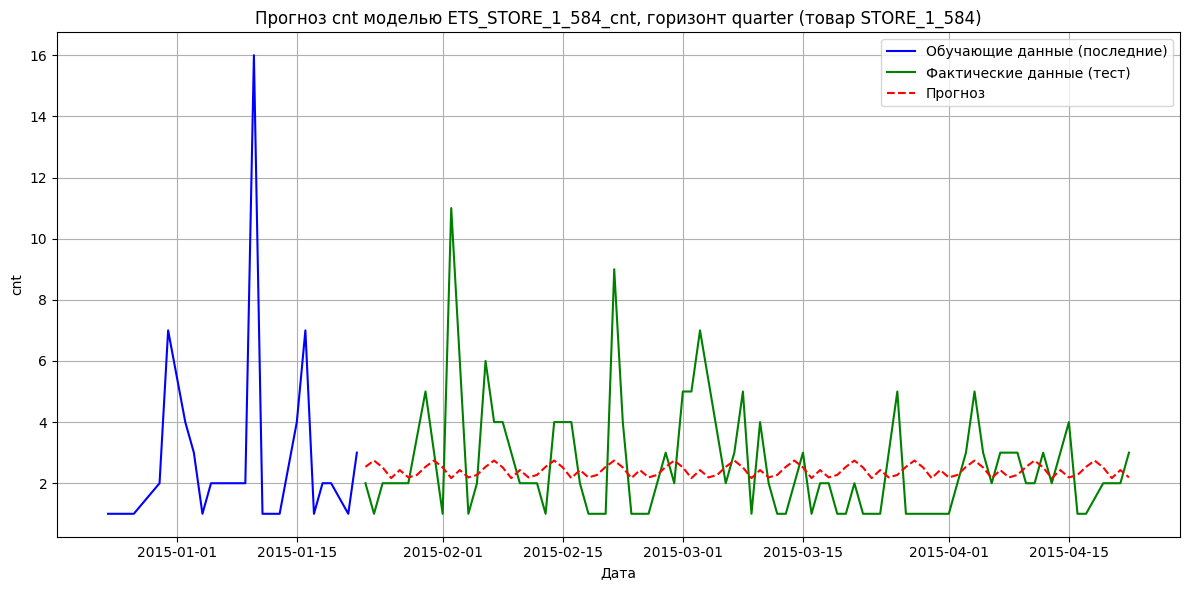


STORE_1_586

=== Прогнозирование по товару STORE_1_586 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_586...

Результаты тестирования моделей для товара STORE_1_586:
                      model   MAE  RMSE  MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7)  6.60  8.31 33.09 -0.94
ETS(t=mul,s=mul,p=7,d=True)  7.02  8.43 34.97 -0.99
ETS(t=add,s=add,p=7,d=True)  7.05  8.84 35.42 -1.19
             ARIMA(3, 1, 3)  9.07 10.33 45.47 -2.00
SARIMA(1, 1, 1)(1, 1, 1, 7)  9.17 10.54 45.16 -2.11
SARIMA(2, 1, 2)(2, 1, 2, 7)  9.38 10.73 46.08 -2.23
             ARIMA(2, 1, 2) 10.52 11.07 51.44 -2.44

Лучшая модель для товара STORE_1_586: SARIMA(1, 1, 2)(0, 1, 2, 7)
  MAE: 6.60, RMSE: 8.31, MAPE: 33.09%, R2: -0.94

Поиск лучшей модели для cnt (month) для товара STORE_1_586...

Результаты тестирования моделей для товара STORE_1_586:
                      model  MAE  RMSE  MAPE    R2
SARIMA(2, 1, 2)(2, 1, 2, 7) 7.47  9.09 30.15  0.27
SARIMA(1, 1, 1)(1, 1, 1, 7) 7.49  9.09 29.96  0.27
ETS(t=add,s=add,

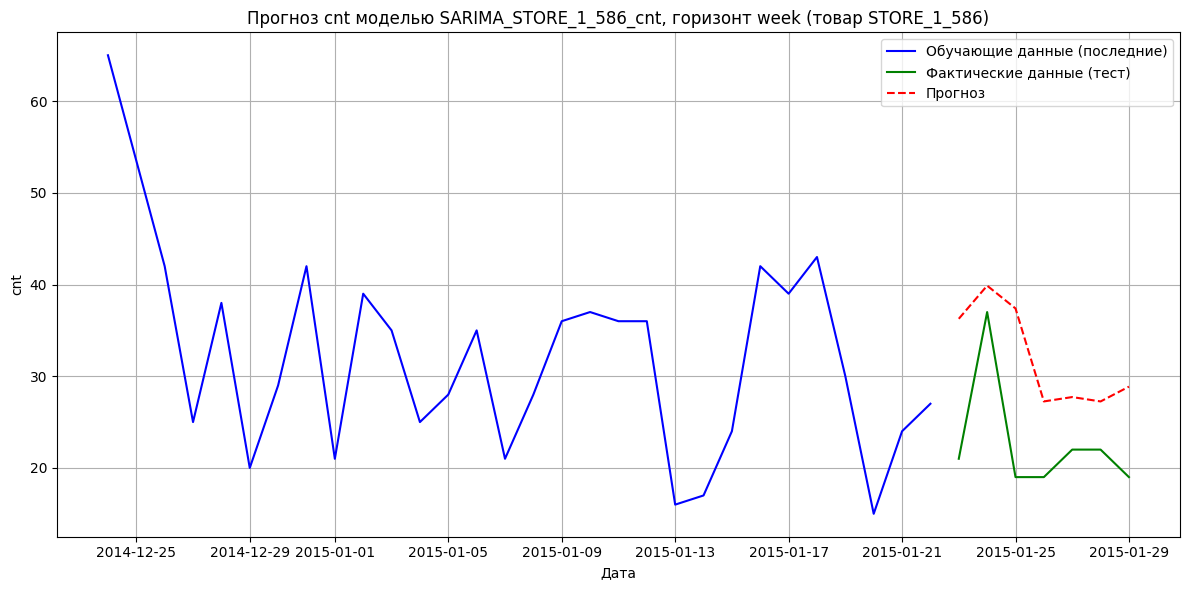

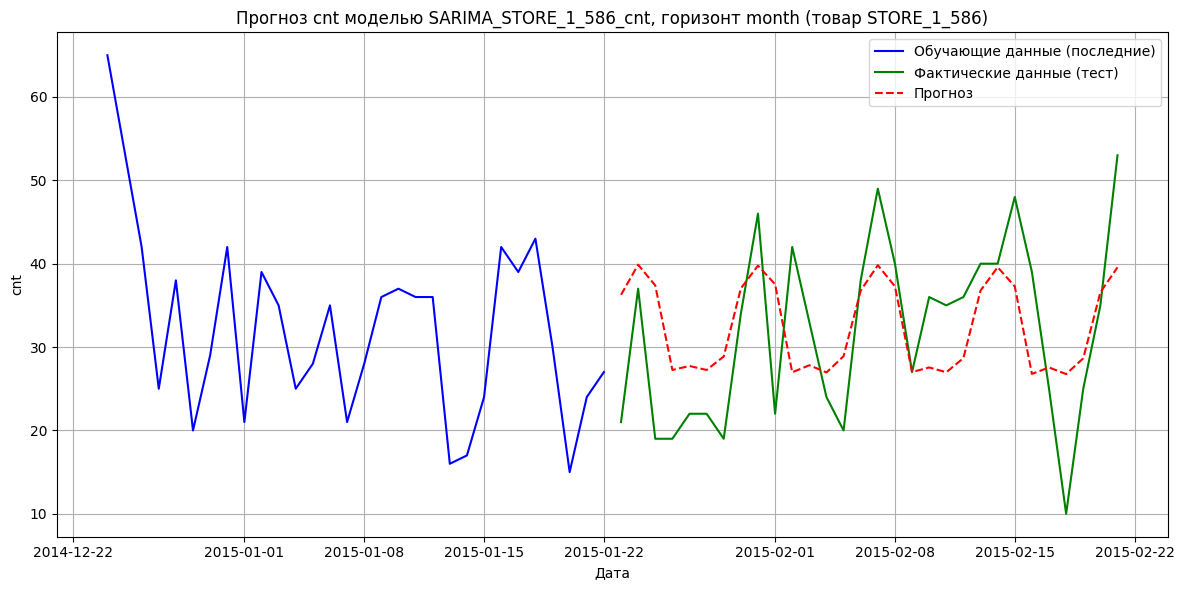

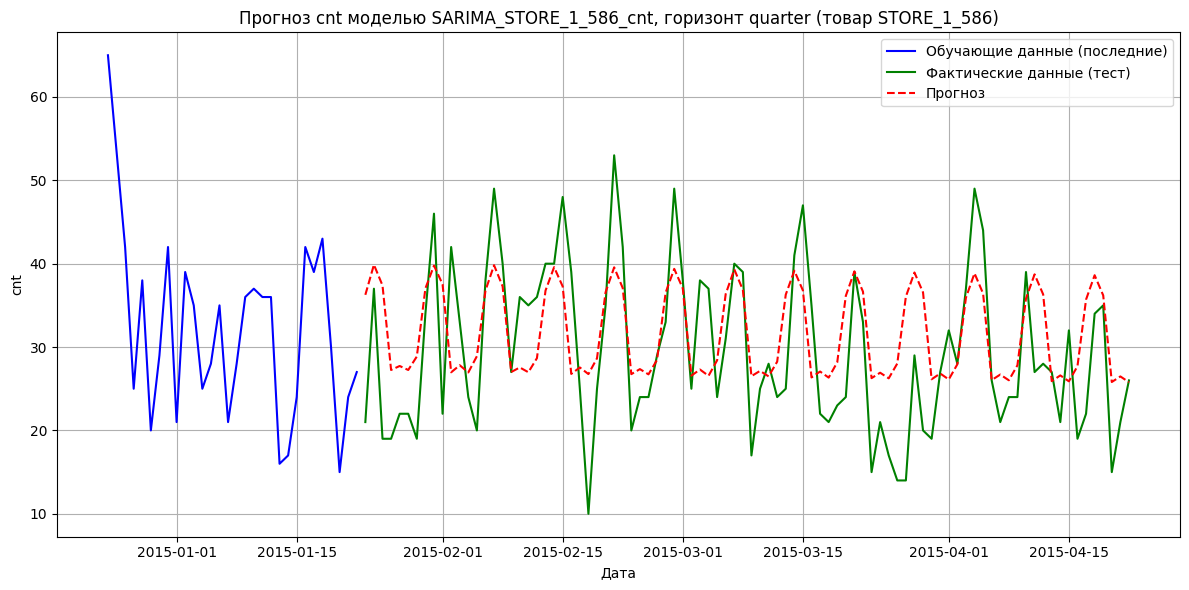


STORE_1_587

=== Прогнозирование по товару STORE_1_587 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_587...

Результаты тестирования моделей для товара STORE_1_587:
                      model   MAE  RMSE   MAPE    R2
ETS(t=add,s=add,p=7,d=True)  4.74  5.62  35.77  0.42
ETS(t=mul,s=mul,p=7,d=True)  4.94  5.99  36.71  0.34
SARIMA(2, 1, 2)(2, 1, 2, 7)  7.96  9.54  67.48 -0.68
SARIMA(1, 1, 1)(1, 1, 1, 7)  8.20  9.48  67.48 -0.66
SARIMA(1, 1, 2)(0, 1, 2, 7)  8.86 10.53  74.58 -1.04
             ARIMA(2, 1, 2)  9.35 11.13  78.52 -1.28
             ARIMA(3, 1, 3) 12.49 14.91 104.83 -3.10

Лучшая модель для товара STORE_1_587: ETS(t=add,s=add,p=7,d=True)
  MAE: 4.74, RMSE: 5.62, MAPE: 35.77%, R2: 0.42

Поиск лучшей модели для cnt (month) для товара STORE_1_587...

Результаты тестирования моделей для товара STORE_1_587:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 1)(1, 1, 1, 7) 6.29  8.12 33.39  0.18
SARIMA(2, 1, 2)(2, 1, 2, 7) 6.54  8.34 36.51  0.14
         

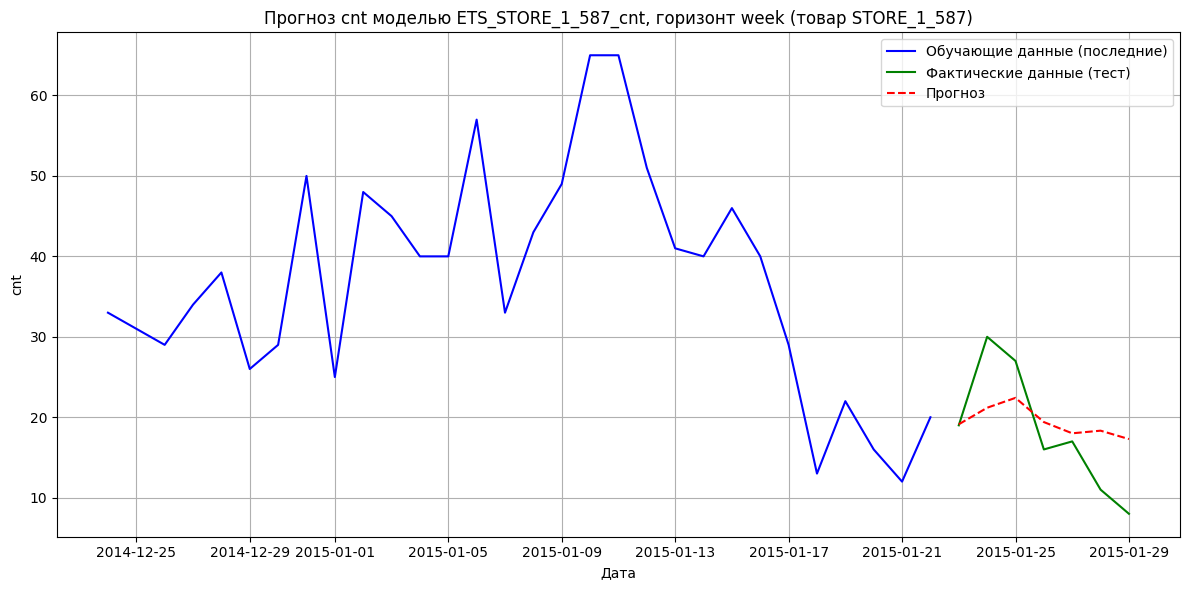

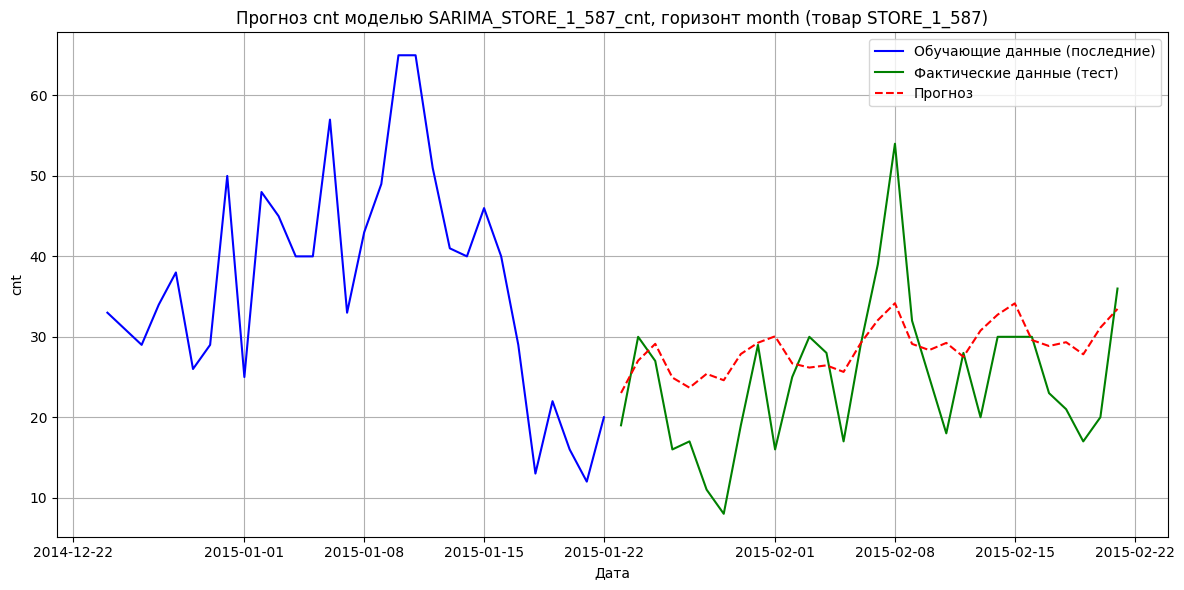

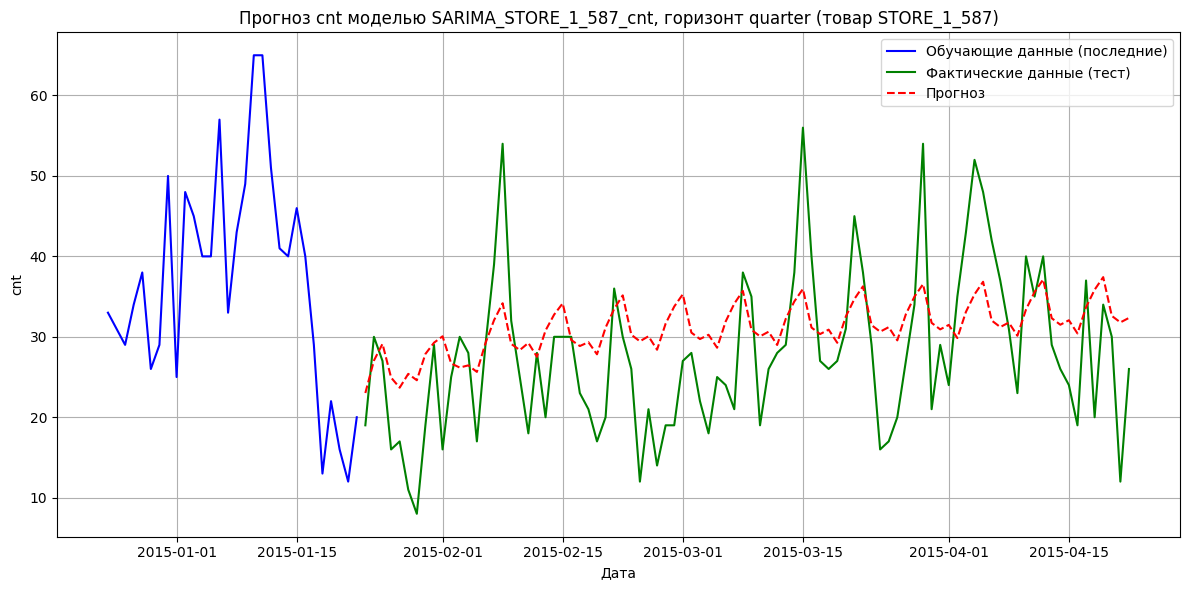


STORE_1_714

=== Прогнозирование по товару STORE_1_714 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_714...

Результаты тестирования моделей для товара STORE_1_714:
                      model  MAE  RMSE  MAPE    R2
             ARIMA(2, 1, 2) 4.97  6.97 25.35 -0.07
             ARIMA(3, 1, 3) 5.15  7.08 26.45 -0.11
ETS(t=mul,s=mul,p=7,d=True) 5.62  6.69 29.41  0.01
SARIMA(1, 1, 2)(0, 1, 2, 7) 5.90  6.48 33.23  0.07
SARIMA(1, 1, 1)(1, 1, 1, 7) 5.94  6.55 33.43  0.05
SARIMA(2, 1, 2)(2, 1, 2, 7) 6.02  6.71 33.90  0.01
ETS(t=add,s=add,p=7,d=True) 6.03  6.58 33.87  0.04

Лучшая модель для товара STORE_1_714: ARIMA(2, 1, 2)
  MAE: 4.97, RMSE: 6.97, MAPE: 25.35%, R2: -0.07

Поиск лучшей модели для cnt (month) для товара STORE_1_714...

Результаты тестирования моделей для товара STORE_1_714:
                      model  MAE  RMSE  MAPE    R2
SARIMA(1, 1, 2)(0, 1, 2, 7) 7.04  8.27 34.75 -0.05
ETS(t=add,s=add,p=7,d=True) 7.04  8.25 34.95 -0.05
SARIMA(2, 1, 2)(2, 1, 2, 7) 7.12  8.3

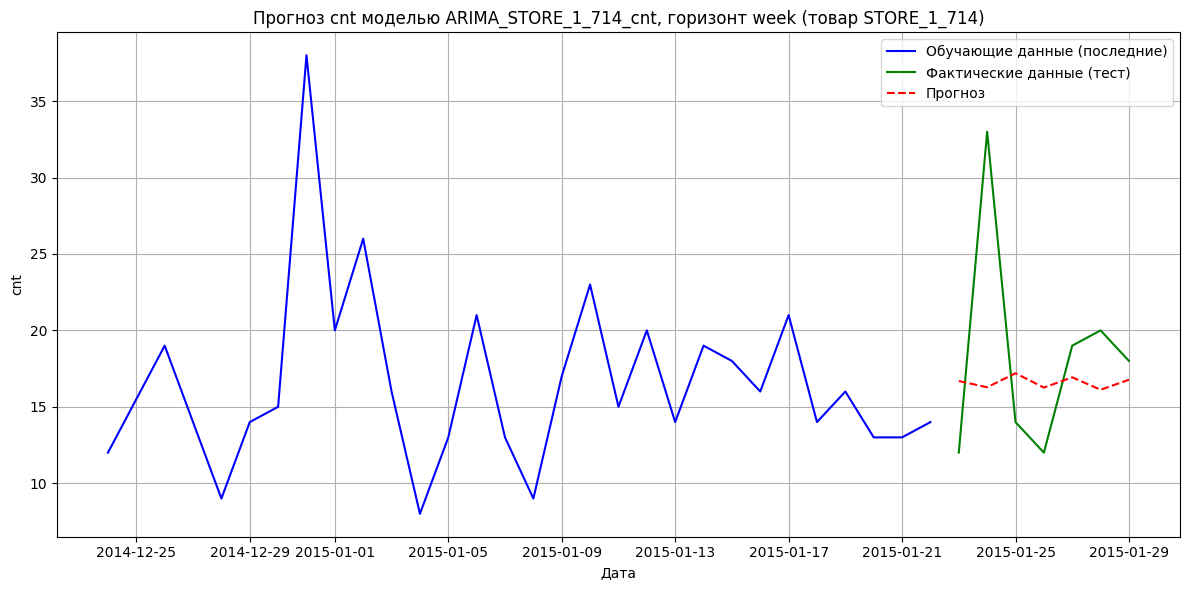

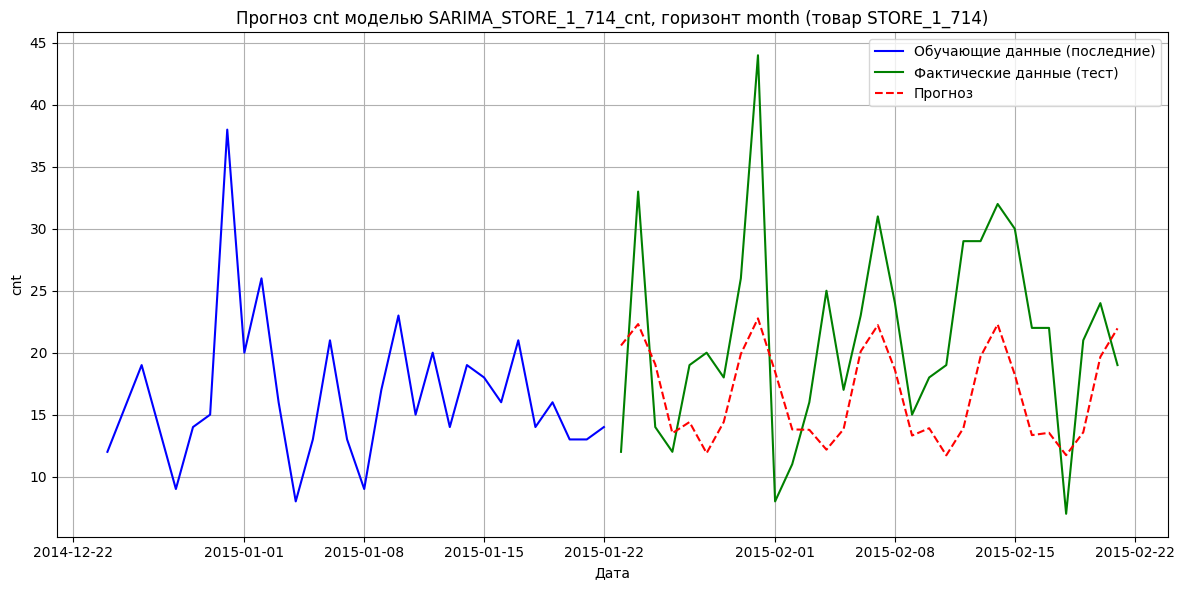

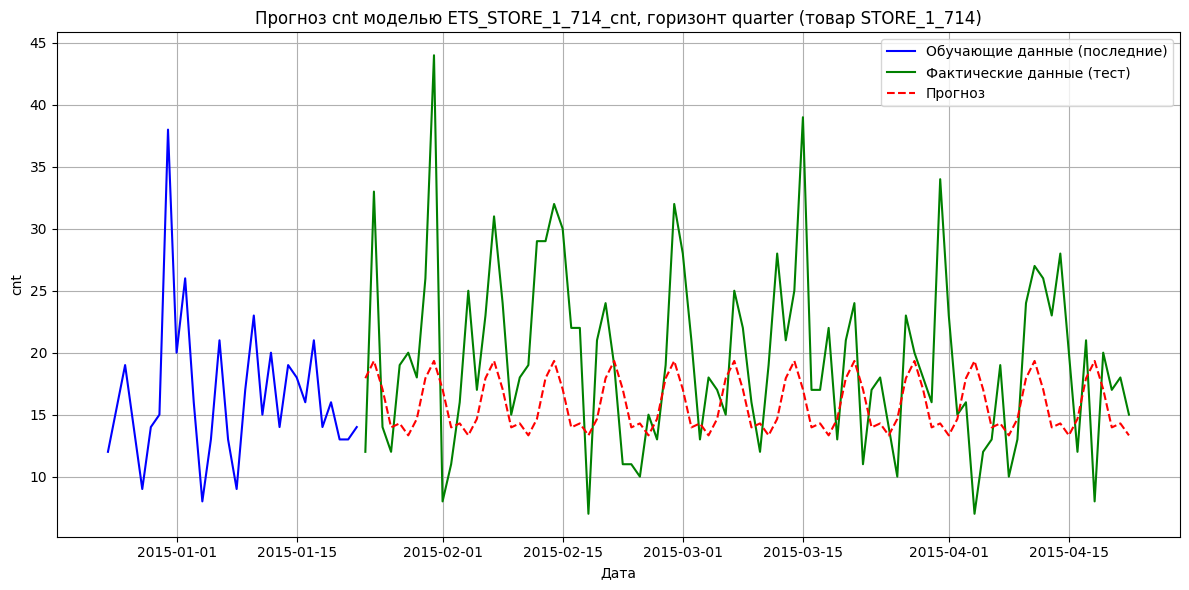


STORE_1_727

=== Прогнозирование по товару STORE_1_727 ===

Поиск лучшей модели для cnt (week) для товара STORE_1_727...

Результаты тестирования моделей для товара STORE_1_727:
                      model  MAE  RMSE   MAPE    R2
ETS(t=add,s=add,p=7,d=True) 1.48  2.08  72.89  0.41
SARIMA(1, 1, 1)(1, 1, 1, 7) 1.58  2.23  76.40  0.32
ETS(t=mul,s=mul,p=7,d=True) 1.71  2.33  83.44  0.26
SARIMA(1, 1, 2)(0, 1, 2, 7) 1.76  2.28 100.06  0.29
SARIMA(2, 1, 2)(2, 1, 2, 7) 1.77  2.30 101.93  0.27
             ARIMA(3, 1, 3) 2.03  2.82  93.48 -0.09
             ARIMA(2, 1, 2) 2.04  2.71 101.61 -0.01

Лучшая модель для товара STORE_1_727: ETS(t=add,s=add,p=7,d=True)
  MAE: 1.48, RMSE: 2.08, MAPE: 72.89%, R2: 0.41

Поиск лучшей модели для cnt (month) для товара STORE_1_727...

Результаты тестирования моделей для товара STORE_1_727:
                      model  MAE  RMSE  MAPE    R2
SARIMA(2, 1, 2)(2, 1, 2, 7) 4.32  5.45 65.78 -0.67
SARIMA(1, 1, 2)(0, 1, 2, 7) 4.32  5.45 65.66 -0.67
ETS(t=add,s=add,p

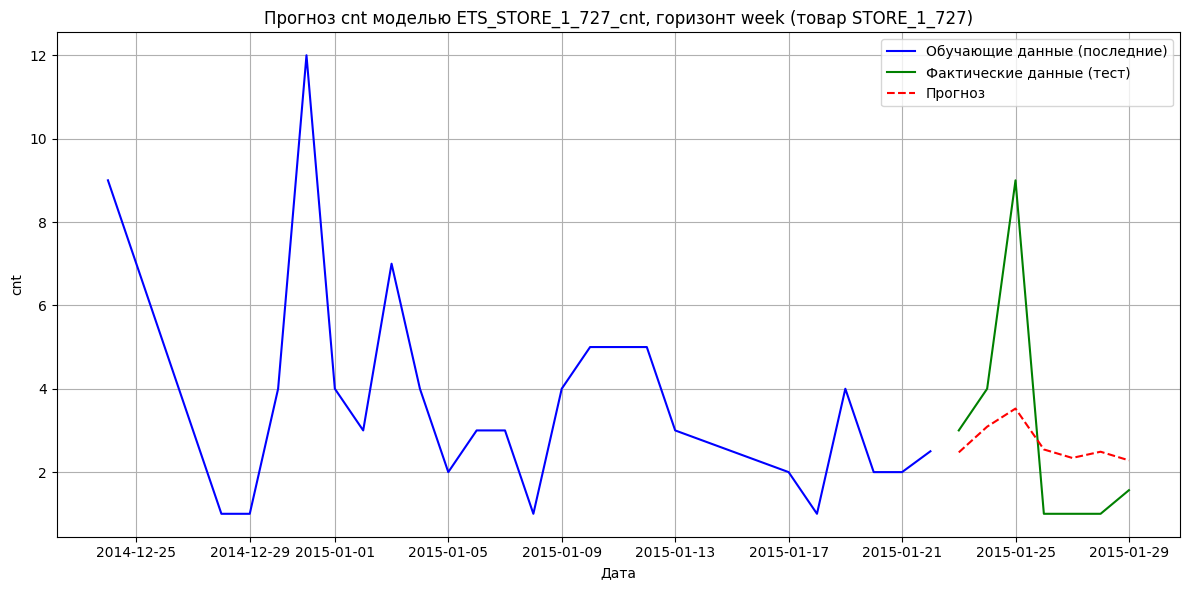

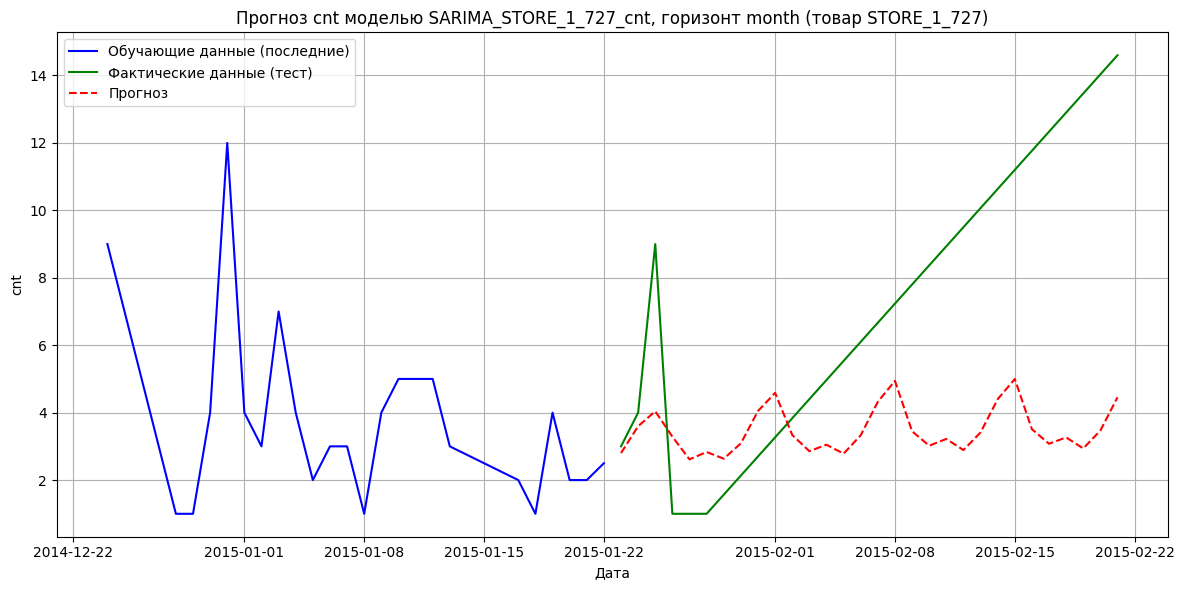

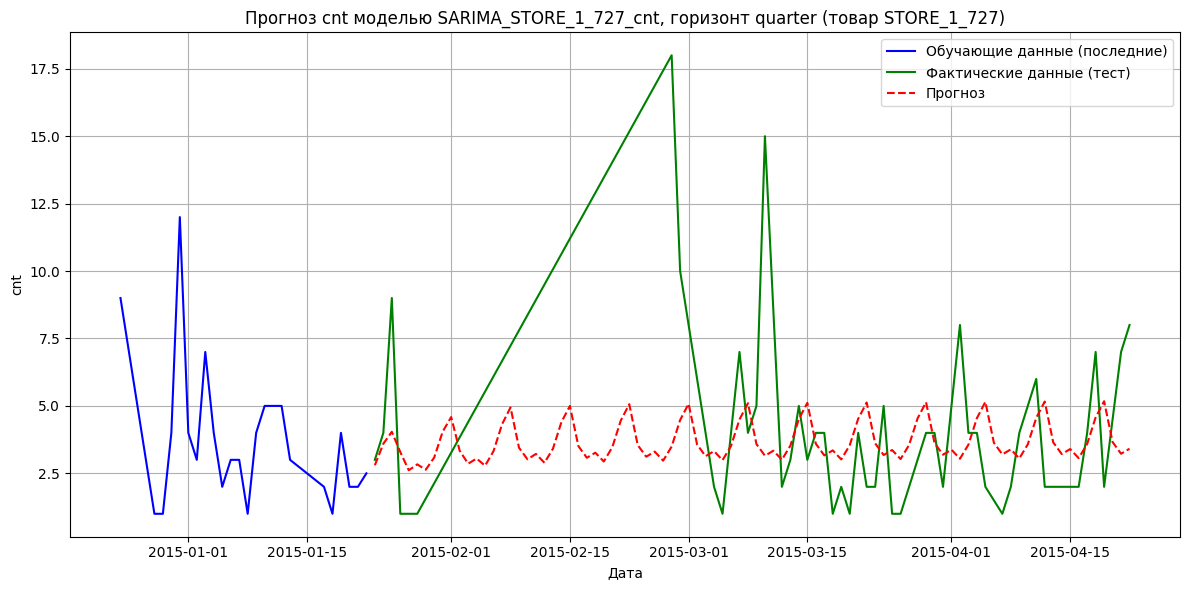

In [1]:
from src.forecasters import ClassicalForecaster
import sys
import os
import pandas as pd

# Создаем экземпляр класса
forecaster = ClassicalForecaster()

# Загружаем и предобрабатываем данные
forecaster.load_and_preprocess_data(
    'data/shop_sales.csv',
    'data/shop_sales_prices.csv',
    'data/shop_sales_dates.csv', 
    store_id='STORE_1'
)

# Разделяем данные на обучающую и тестовую выборки
forecaster.train_test_split(test_size=0.2)

# Создаем датафреймы для прогнозов
week_forecasts = pd.DataFrame()
month_forecasts = pd.DataFrame()
quarter_forecasts = pd.DataFrame()


for item in forecaster.items[:]: 
    print('')
    print(item)
    # Выберем первый товар из списка для примера
    example_item = item
    print(f"\n=== Прогнозирование по товару {example_item} ===")

    best_item_model_week, _ = forecaster.find_best_classical_model('cnt', horizon='week', item_id=example_item)
    best_item_model_month, _ = forecaster.find_best_classical_model('cnt', horizon='month', item_id=example_item)
    best_item_model_quarter, _ = forecaster.find_best_classical_model('cnt', horizon='quarter', item_id=example_item)
    
    # Получаем прогнозы
    forecast_week = forecaster.forecasts[best_item_model_week].copy()
    forecast_month = forecaster.forecasts[best_item_model_month].copy()
    forecast_quarter = forecaster.forecasts[best_item_model_quarter].copy()
    
    # Добавляем идентификатор товара
    forecast_week['item_id'] = item
    forecast_month['item_id'] = item
    forecast_quarter['item_id'] = item
    
    # Добавляем к общим датафреймам
    week_forecasts = pd.concat([week_forecasts, forecast_week])
    month_forecasts = pd.concat([month_forecasts, forecast_month])
    quarter_forecasts = pd.concat([quarter_forecasts, forecast_quarter])
    
    # Визуализируем прогнозы для выбранного товара
    print(f"\n=== Визуализация прогнозов для товара {example_item} ===")
    forecaster.visualize_forecast(best_item_model_week, horizon='week')
    forecaster.visualize_forecast(best_item_model_month, horizon='month')
    forecaster.visualize_forecast(best_item_model_quarter, horizon='quarter')


# 4. Анализ результатов и выводы

## 4.1 Оптимальный подход к прогнозированию в рамках исследования

Эмпирический анализ результатов прогнозирования для 15 товаров магазина `STORE_1` (на основе предоставленных логов) не выявил универсально доминирующей модели среди протестированных классических методов (ARIMA, SARIMA, ETS). Оптимальная модель и ее конфигурация продемонстрировали зависимость как от специфических характеристик временного ряда конкретного товара, так и от выбранного горизонта прогнозирования.

Ввиду отсутствия единого наилучшего решения, **наиболее эффективным подходом в рамках данного исследования является реализованная стратегия адаптивного выбора модели.** Эта стратегия включает:
1.  Определение набора репрезентативных конфигураций для каждого семейства моделей (ARIMA, SARIMA, ETS).
2.  Итеративное обучение и оценка каждой конфигурации на временном ряду конкретного товара (`item_id`) для заданного горизонта прогнозирования (`horizon`).
3.  Выбор модели, демонстрирующей минимальное значение метрики MAE на тестовой выборке.

Данный подход позволяет максимально использовать возможности протестированных классических методов путем их индивидуальной настройки для каждой конкретной задачи прогнозирования "товар-горизонт".

## 4.2 Итоговое качество моделей на тестовом датасете (Магазин STORE_1)

**Важное примечание:** Представленные ниже детальные результаты и выводы основаны **исключительно на данных магазина `STORE_1`**, согласно предоставленным логам выполнения. Для получения картины по другим магазинам требуется отдельный запуск анализа.

Оценка качества лучших моделей, подобранных адаптивно для каждого товара магазина `STORE_1`, на тестовом датасете (период с 2015-01-23 по 2016-01-21) выявила следующие закономерности:

**Сводная таблица результатов для STORE_1 (по лучшей модели для каждого случая):**

| Товар        | Горизонт | Лучшая модель                  | MAE   | RMSE  | MAPE (%) | R2    |
| :----------- | :------- | :----------------------------- | :---- | :---- | :------- | :---- |
| STORE_1_064  | Неделя   | ETS(t=add,s=add,p=7,d=True)    | 0.02  | 0.02  | 1.76     | 0.00  |
|              | Месяц    | ETS(t=add,s=add,p=7,d=True)    | 0.08  | 0.22  | 5.39     | -0.06 |
|              | Квартал  | ETS(t=add,s=add,p=7,d=True)    | 0.21  | 0.42  | 11.62    | -0.23 |
| STORE_1_065  | Неделя   | SARIMA(1,1,1)(1,1,1,7)         | 0.30  | 0.35  | 24.34    | 0.03  |
|              | Месяц    | ETS(t=mul,s=mul,p=7,d=True)    | 0.27  | 0.30  | 25.38    | -0.69 |
|              | Квартал  | ETS(t=mul,s=mul,p=7,d=True)    | 0.41  | 0.53  | 27.35    | -0.06 |
| STORE_1_325  | Неделя   | SARIMA(1,1,2)(0,1,2,7)         | 1.93  | 2.35  | 127.51   | 0.17  |
|              | Месяц    | ETS(t=add,s=add,p=7,d=True)    | 2.79  | 4.03  | 99.95    | 0.00  |
|              | Квартал  | ETS(t=add,s=add,p=7,d=True)    | 3.27  | 4.38  | 82.91    | -0.10 |
| STORE_1_376  | Неделя   | ARIMA(3,1,3)                   | 0.91  | 0.99  | 72.39    | -3.56 |
|              | Месяц    | ARIMA(2,1,2)                   | 0.91  | 1.17  | 62.74    | -0.16 |
|              | Квартал  | ARIMA(2,1,2)                   | 0.88  | 1.19  | 52.66    | -0.03 |
| STORE_1_090  | Неделя   | SARIMA(1,1,1)(1,1,1,7)         | 11.78 | 13.45 | 18.36    | 0.74  |
|              | Месяц    | SARIMA(1,1,1)(1,1,1,7)         | 15.73 | 20.94 | 27.72    | 0.30  |
|              | Квартал  | SARIMA(1,1,1)(1,1,1,7)         | 15.73 | 22.47 | 71.26    | 0.18  |
| STORE_1_252  | Неделя   | ETS(t=mul,s=mul,p=7,d=True)    | 2.05  | 2.53  | 41.35    | 0.11  |
|              | Месяц    | ARIMA(3,1,3)                   | 5.23  | 6.41  | 52.53    | -0.28 |
|              | Квартал  | ARIMA(3,1,3)                   | 5.21  | 6.82  | 42.67    | -0.28 |
| STORE_1_339  | Неделя   | SARIMA(1,1,2)(0,1,2,7)         | 1.74  | 2.07  | 85.46    | 0.32  |
|              | Месяц    | SARIMA(1,1,2)(0,1,2,7)         | 1.94  | 2.43  | 57.92    | 0.05  |
|              | Квартал  | SARIMA(1,1,2)(0,1,2,7)         | 2.14  | 3.03  | 76.87    | 0.03  |
| STORE_1_546  | Неделя   | SARIMA(1,1,2)(0,1,2,7)         | 1.08  | 1.22  | 74.61    | -72.30|
|              | Месяц    | SARIMA(1,1,2)(0,1,2,7)         | 1.27  | 1.70  | 61.37    | -0.19 |
|              | Квартал  | ETS(t=mul,s=mul,p=7,d=True)    | 1.83  | 2.47  | 59.44    | -0.12 |
| STORE_1_547  | Неделя   | ARIMA(3,1,3)                   | 0.78  | 0.80  | 14.36    | 0.13  |
|              | Месяц    | ARIMA(3,1,3)                   | 5.93  | 8.59  | 33.71    | -0.49 |
|              | Квартал  | ARIMA(3,1,3)                   | 6.80  | 11.04 | 52.44    | -0.25 |
| STORE_1_555  | Неделя   | ETS(t=mul,s=mul,p=7,d=True)    | 2.11  | 2.41  | 14.76    | -0.32 |
|              | Месяц    | ARIMA(3,1,3)                   | 6.05  | 8.13  | 26.95    | -0.13 |
|              | Квартал  | ARIMA(3,1,3)                   | 5.35  | 7.14  | 26.86    | -0.08 |
| STORE_1_584  | Неделя   | ETS(t=mul,s=mul,p=7,d=True)    | 0.69  | 0.87  | 43.08    | -0.67 |
|              | Месяц    | ETS(t=add,s=add,p=7,d=True)    | 1.55  | 2.39  | 59.63    | -0.04 |
|              | Квартал  | ETS(t=mul,s=mul,p=7,d=True)    | 1.30  | 1.82  | 62.88    | -0.01 |
| STORE_1_586  | Неделя   | SARIMA(1,1,2)(0,1,2,7)         | 6.60  | 8.31  | 33.09    | -0.94 |
|              | Месяц    | SARIMA(2,1,2)(2,1,2,7)         | 7.47  | 9.09  | 30.15    | 0.27  |
|              | Квартал  | SARIMA(1,1,2)(0,1,2,7)         | 6.29  | 7.98  | 23.34    | 0.31  |
| STORE_1_587  | Неделя   | ETS(t=add,s=add,p=7,d=True)    | 4.74  | 5.62  | 35.77    | 0.42  |
|              | Месяц    | SARIMA(1,1,1)(1,1,1,7)         | 6.29  | 8.12  | 33.39    | 0.18  |
|              | Квартал  | SARIMA(1,1,1)(1,1,1,7)         | 6.73  | 8.77  | 28.00    | 0.22  |
| STORE_1_714  | Неделя   | ARIMA(2,1,2)                   | 4.97  | 6.97  | 25.35    | -0.07 |
|              | Месяц    | SARIMA(1,1,2)(0,1,2,7)         | 7.04  | 8.27  | 34.75    | -0.05 |
|              | Квартал  | ETS(t=add,s=add,p=7,d=True)    | 5.75  | 7.38  | 31.79    | -0.06 |
| STORE_1_727  | Неделя   | ETS(t=add,s=add,p=7,d=True)    | 1.48  | 2.08  | 72.89    | 0.41  |
|              | Месяц    | SARIMA(2,1,2)(2,1,2,7)         | 4.32  | 5.45  | 65.78    | -0.67 |
|              | Квартал  | SARIMA(1,1,2)(0,1,2,7)         | 3.53  | 5.08  | 69.68    | -0.25 |

**Основные результаты анализа (для STORE_1):**

1.  **Высокая гетерогенность точности:** Качество прогнозов сильно различается между товарами. Например, для `STORE_1_064` на недельном горизонте MAE составляет всего 0.02, тогда как для `STORE_1_090` - 11.78.
2.  **Деградация точности с увеличением горизонта:** Качество прогнозов систематически снижается при переходе от недельного к месячному и квартальному горизонтам. Это особенно заметно по метрике R², которая для многих товаров становится отрицательной на горизонтах месяц и квартал, указывая, что модель работает хуже, чем простое прогнозирование средним значением.
3.  **Проблемы интерпретации MAPE:** Высокие значения MAPE (часто > 50-100%) для многих товаров (`STORE_1_325`, `STORE_1_376`, `STORE_1_546`, `STORE_1_727` и др.) могут быть обусловлены малыми объемами продаж (наличием нулей или близких к нулю значений в знаменателе формулы MAPE), что делает эту метрику менее надежной для сравнения таких рядов.
4.  **Доминирование разных моделей:** Нет одной модели, которая была бы лучшей для всех товаров и горизонтов. ETS, SARIMA и ARIMA выбираются как лучшие в разных случаях, подтверждая целесообразность адаптивного подхода.

**Вывод по качеству (для STORE_1):**
Проведенный анализ показал, что предсказательная способность классических моделей временных рядов (ARIMA, SARIMA, ETS) при прогнозировании продаж отдельных товаров в магазине `STORE_1` является **ограниченной и нестабильной**, особенно для среднесрочных (месяц) и долгосрочных (квартал) прогнозов. Несмотря на применение адаптивной стратегии выбора лучшей модели, достигнутое качество (судя по часто отрицательным R² и высоким MAPE для некоторых товаров) часто не соответствует требованиям для надежного бизнес-планирования на уровне отдельных SKU.

**Итоговое заключение:**
Применение классических моделей ARIMA, SARIMA и ETS с использованием адаптивного подбора параметров позволило получить прогнозы продаж для магазина `STORE_1`. Наблюдается значительная вариативность точности прогнозов в зависимости от товара и горизонта прогнозирования. Результаты подтверждают тенденцию к снижению точности моделей при увеличении горизонта. Полученные метрики могут служить базовой линией (baseline) для сравнения с альтернативными, потенциально более сложными методами прогнозирования. Дальнейшее повышение точности прогнозов может потребовать исследования моделей иной природы (например, основанных на машинном обучении с использованием дополнительных признаков) и/или более тонкой настройки параметров классических моделей и методов предобработки.